In [1]:
####adal解决已知qp问题
import numpy as np
from scipy.linalg import solve
from scipy.optimize import minimize
import warnings
from cvxopt import matrix, solvers

def ADAL(A1, A2, b1, b2, g, H,
         rho_eq=10.0, rho_ineq=10.0, alpha=1.0,
         max_iter=1000, tol=1e-5):
    """
    ADAL（Alternating Direction Augmented Lagrangian）求解器的实现。
    
    参数:
        A1 (numpy.ndarray): 等式约束矩阵，形状为 (m1, n)。
        A2 (numpy.ndarray): 不等式约束矩阵，形状为 (m2, n)。
        b1 (numpy.ndarray): 等式约束右侧向量，形状为 (m1,)。
        b2 (numpy.ndarray): 不等式约束右侧向量，形状为 (m2,)。
        g (numpy.ndarray): 目标函数的一次项向量，形状为 (n,)。
        H (numpy.ndarray): 目标函数的二次项矩阵，形状为 (n, n)。
        rho_eq (float): 等式约束的罚参数。
        rho_ineq (float): 不等式约束的罚参数。
        alpha (float): 步长参数（通常在 (0, 2)）。
        max_iter (int): 最大迭代次数。
        tol (float): 收敛容忍度。
    
    返回:
        x (numpy.ndarray): 最优解向量，形状为 (n,)。
        history (dict): 包含目标函数值和残差的历史记录。
    """
    m1, n = A1.shape
    m2 = A2.shape[0]

    # 初始化变量
    x = np.zeros(n)
    lambda_eq = np.zeros(m1)
    lambda_ineq = np.zeros(m2)

    # 历史记录
    history = {'obj': [], 'primal_eq': [], 'primal_ineq': [], 'dual_eq': [], 'dual_ineq': []}

    for k in range(max_iter):
        # 保存旧的变量
        x_old = x.copy()

        # 计算梯度
        grad = H @ x + g + A1.T @ lambda_eq + A2.T @ lambda_ineq

        # 构造加权的二次项矩阵 H_reg = H + rho_eq * A1^T A1 + rho_ineq * A2_active^T A2_active
        # 仅对违反不等式约束的 A2 行进行加权
        active_ineq = A2 @ x - b2 > 0
        A2_active = A2[active_ineq]
        lambda_ineq_active = lambda_ineq[active_ineq]
        rho_ineq_active = rho_ineq if np.any(active_ineq) else 0.0

        # 构造 H_reg
        H_reg = H.copy()
        if m1 > 0:
            H_reg += rho_eq * (A1.T @ A1)
        if np.any(active_ineq):
            H_reg += rho_ineq_active * (A2_active.T @ A2_active)

        # 构造 h = g + A1^T lambda_eq + A2_active^T lambda_ineq_active + rho_eq * A1^T b1
        h = g.copy()
        if m1 > 0:
            h += A1.T @ lambda_eq
            h += rho_eq * (A1.T @ b1)
        if np.any(active_ineq):
            h += A2_active.T @ lambda_ineq_active

        # 求解子问题 H_reg x = -h
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("error", category=RuntimeWarning)
                x = solve(H_reg, -h)
        except np.linalg.LinAlgError as e:
            print(f"线性系统求解失败：{e}")
            break
        except RuntimeWarning as e:
            print(f"线性系统求解过程中出现警告：{e}")
            break

        # 更新拉格朗日乘子
        residual_eq = A1 @ x + b1 if m1 > 0 else np.array([])
        residual_ineq = A2 @ x - b2

        if m1 > 0:
            lambda_eq += rho_eq * residual_eq

        # 仅对违反不等式约束的拉格朗日乘子进行更新，并保持其非负
        lambda_ineq += rho_ineq * residual_ineq
        lambda_ineq = np.maximum(lambda_ineq, 0)

        # 计算目标函数值
        obj = 0.5 * x.T @ H @ x + g.T @ x

        # 记录历史
        history['obj'].append(obj)
        history['primal_eq'].append(np.linalg.norm(residual_eq, ord=np.inf) if m1 > 0 else 0.0)
        history['primal_ineq'].append(np.linalg.norm(np.maximum(residual_ineq, 0), ord=np.inf))
        history['dual_eq'].append(np.linalg.norm(lambda_eq, ord=np.inf))
        history['dual_ineq'].append(np.linalg.norm(lambda_ineq, ord=np.inf))

        # 计算收敛标准
        norm_diff = np.linalg.norm(x - x_old)
        if (norm_diff < tol and
            (m1 == 0 or history['primal_eq'][-1] < tol) and
            history['primal_ineq'][-1] < tol):
            print(f"ADAL 收敛于迭代次数：{k+1}")
            break

        # 调试信息
        if k % 100 == 0 or k == max_iter - 1:
            print(f"迭代 {k+1}: Obj = {obj:.6f}, ||Δx|| = {norm_diff:.6e}, "
                  f"Primal Residual Eq = {history['primal_eq'][-1]:.6e}, "
                  f"Primal Residual Inq = {history['primal_ineq'][-1]:.6e}, "
                  f"Dual Residual Eq = {history['dual_eq'][-1]:.6e}, "
                  f"Dual Residual Inq = {history['dual_ineq'][-1]:.6e}")

    else:
        print("ADAL 达到最大迭代次数。")

    return x, history

def solve_qp_with_SLSQP(A1, A2, b1, b2, g, H):
    """
    使用 scipy.optimize.minimize 的 SLSQP 方法求解 QP 问题。

    参数：
        A1, A2 : 等式和不等式约束的系数矩阵
        b1, b2 : 等式和不等式约束的常数向量
        g, H   : 目标函数的线性和二次项

    返回：
        result.x : 最优解 x
        result : 求解器的完整结果对象
    """
    # 定义目标函数
    def objective(x):
        return 0.5 * np.dot(x, H @ x) + np.dot(g, x)
    
    # 定义约束
    constraints = []
    for i in range(A1.shape[0]):
        constraints.append({
            'type': 'eq',
            'fun': lambda x, A=A1[i], b=b1[i]: np.dot(A, x) + b
        })
    for i in range(A2.shape[0]):
        constraints.append({
            'type': 'ineq',
            'fun': lambda x, A=A2[i], b=b2[i]: b - np.dot(A, x)  # 正确地定义 A2x <= b2 为 b2 - A2x >=0
        })
    
    # 初始点
    x0 = np.zeros(A1.shape[1])
    
    # 优化
    result = minimize(objective, x0, method='SLSQP', constraints=constraints)
    
    return result.x, result

def solve_qp_with_CVXOPT(A1, A2, b1, b2, g, H):
    """
    使用 CVXOPT 库求解 QP 问题。

    参数：
        A1, A2 : 等式和不等式约束的系数矩阵
        b1, b2 : 等式和不等式约束的常数向量
        g, H   : 目标函数的线性和二次项

    返回：
        x (numpy.ndarray): 最优解 x
        status (str): 求解状态
    """
    # 转换数据类型为 CVXOPT 矩阵
    P = matrix(H)
    q = matrix(g)
    
    # 不等式约束 Gx <= h
    G = matrix(A2)
    h = matrix(b2)
    
    # 等式约束 Ax = b
    A = matrix(A1)
    b = matrix(-b1)  # 修正：将等式约束右侧设置为 -b1
    
    # 设置求解器参数
    solvers.options['show_progress'] = False  # 关闭求解器的进度输出
    
    # 求解 QP 问题
    solution = solvers.qp(P, q, G, h, A, b)
    
    # 提取解和状态
    x = np.array(solution['x']).flatten()
    status = solution['status']
    
    return x, status

def verify_constraints(A1, A2, b1, b2, x):
    """
    验证解是否满足所有等式和不等式约束。

    参数：
        A1, A2 : 等式和不等式约束的系数矩阵
        b1, b2 : 等式和不等式约束的常数向量
        x      : 解向量

    返回：
        eq_residual : 等式约束的最大残差
        ineq_residual : 不等式约束的最大残差
    """
    if A1.size > 0:
        eq_residual = np.linalg.norm(A1 @ x + b1, ord=np.inf)
    else:
        eq_residual = 0.0
    if A2.size > 0:
        ineq_residual = np.linalg.norm(np.maximum(A2 @ x - b2, 0), ord=np.inf)
    else:
        ineq_residual = 0.0
    return eq_residual, ineq_residual

def compute_objective(x, g, H):
    """
    计算目标函数值。

    参数：
        x : 解向量
        g, H : 目标函数的线性和二次项

    返回：
        obj_val : 目标函数值
    """
    return 0.5 * x.T @ H @ x + g.T @ x

def main():
    """
    主函数，用于定义测试问题并运行求解器。
    """
    # 定义一个具体的二次规划问题
    # 目标函数: (1/2) * x^T * H * x + g^T * x
    # 约束条件: A1 * x + b1 = 0 （等式约束）
    #            A2 * x <= b2 （不等式约束）

    # 示例数据（确保x满足所有约束，保证可行性）
    n, m1, m2 = 2, 1, 2  # 变量数、等式约束数、不等式约束数
    H = np.array([[2, 0],
                  [0, 2]], dtype=np.float64)  # 目标函数的二次项矩阵（保证正定性）
    g = np.array([-2, -5], dtype=np.float64)  # 目标函数的一次项向量

    # 等式约束 A1 x + b1 = 0
    A1 = np.array([
        [1, 1]
    ], dtype=np.float64)
    b1 = np.array([-5], dtype=np.float64)  # 例如 x1 + x2 = 5

    # 不等式约束 A2 x <= b2
    A2 = np.array([
        [1, 2],
        [3, 2]
    ], dtype=np.float64)
    b2 = np.array([10, 12], dtype=np.float64)  # 例如 1*x1 +2*x2 <=10, 3*x1 +2*x2 <=12

    # 运行 ADAL、SLSQP 和 CVXOPT 求解器
    print("\n=== ADAL 与 SLSQP 与 CVXOPT 求解器比较 ===")

    # 使用 ADAL 求解器
    print("\n--- ADAL 求解器 ---")
    x_adal, history_adal = ADAL(A1, A2, b1, b2, g, H)
    print("\nADAL 解决方案 x:", x_adal)
    eq_residual_adal, ineq_residual_adal = verify_constraints(A1, A2, b1, b2, x_adal)
    obj_adal = compute_objective(x_adal, g, H)
    print(f"ADAL 目标函数值: {obj_adal:.6f}")
    print(f"ADAL 等式约束残差: {eq_residual_adal:.6e}, 不等式约束残差: {ineq_residual_adal:.6e}")

    # 使用 SLSQP 求解器
    print("\n--- SLSQP 求解器 ---")
    x_slsqp, result_slsqp = solve_qp_with_SLSQP(A1, A2, b1, b2, g, H)
    print("\nSLSQP 解决方案 x:", x_slsqp)
    print("SLSQP Success:", result_slsqp.success)
    print("SLSQP Message:", result_slsqp.message)
    eq_residual_slsqp, ineq_residual_slsqp = verify_constraints(A1, A2, b1, b2, x_slsqp)
    obj_slsqp = compute_objective(x_slsqp, g, H)
    print(f"SLSQP 目标函数值: {obj_slsqp:.6f}")
    print(f"SLSQP 等式约束残差: {eq_residual_slsqp:.6e}, 不等式约束残差: {ineq_residual_slsqp:.6e}")

    # 使用 CVXOPT 求解器
    print("\n--- CVXOPT 求解器 ---")
    x_cvxopt, status_cvxopt = solve_qp_with_CVXOPT(A1, A2, b1, b2, g, H)
    print("\nCVXOPT 解决方案 x:", x_cvxopt)
    print("CVXOPT Status:", status_cvxopt)
    eq_residual_cvxopt, ineq_residual_cvxopt = verify_constraints(A1, A2, b1, b2, x_cvxopt)
    obj_cvxopt = compute_objective(x_cvxopt, g, H)
    print(f"CVXOPT 目标函数值: {obj_cvxopt:.6f}")
    print(f"CVXOPT 等式约束残差: {eq_residual_cvxopt:.6e}, 不等式约束残差: {ineq_residual_cvxopt:.6e}")

    # 对比三个解
    difference_adal_slsqp = np.linalg.norm(x_adal - x_slsqp)
    difference_adal_cvxopt = np.linalg.norm(x_adal - x_cvxopt)
    difference_slsqp_cvxopt = np.linalg.norm(x_slsqp - x_cvxopt)
    print(f"\nDifference between ADAL and SLSQP solutions (Euclidean norm): {difference_adal_slsqp:.6e}")
    print(f"Difference between ADAL and CVXOPT solutions (Euclidean norm): {difference_adal_cvxopt:.6e}")
    print(f"Difference between SLSQP and CVXOPT solutions (Euclidean norm): {difference_slsqp_cvxopt:.6e}")

    # 总结
    tolerance = 1e-4
    consistent_adal_slsqp = difference_adal_slsqp <= tolerance
    consistent_adal_cvxopt = difference_adal_cvxopt <= tolerance
    consistent_slsqp_cvxopt = difference_slsqp_cvxopt <= tolerance

    if consistent_adal_slsqp and consistent_adal_cvxopt and consistent_slsqp_cvxopt:
        print("\nADAL、SLSQP 和 CVXOPT 求解器的解一致。")
    else:
        print("\nADAL、SLSQP 和 CVXOPT 求解器的解存在显著差异。")
        print("请检查 ADAL 的实现或参数设置是否正确。")

if __name__ == "__main__":
    main()



=== ADAL 与 SLSQP 与 CVXOPT 求解器比较 ===

--- ADAL 求解器 ---
迭代 1: Obj = -6.320248, ||Δx|| = 3.598955e+00, Primal Residual Eq = 1.363636e-01, Primal Residual Inq = 0.000000e+00, Dual Residual Eq = 1.363636e+00, Dual Residual Inq = 0.000000e+00
ADAL 收敛于迭代次数：6

ADAL 解决方案 x: [1.74999958 3.24999958]
ADAL 目标函数值: -6.125001
ADAL 等式约束残差: 8.467109e-07, 不等式约束残差: 0.000000e+00

--- SLSQP 求解器 ---

SLSQP 解决方案 x: [1.75 3.25]
SLSQP Success: True
SLSQP Message: Optimization terminated successfully
SLSQP 目标函数值: -6.125000
SLSQP 等式约束残差: 0.000000e+00, 不等式约束残差: 0.000000e+00

--- CVXOPT 求解器 ---

CVXOPT 解决方案 x: [1.74999916 3.25000084]
CVXOPT Status: optimal
CVXOPT 目标函数值: -6.125000
CVXOPT 等式约束残差: 0.000000e+00, 不等式约束残差: 0.000000e+00

Difference between ADAL and SLSQP solutions (Euclidean norm): 5.987150e-07
Difference between ADAL and CVXOPT solutions (Euclidean norm): 1.335421e-06
Difference between SLSQP and CVXOPT solutions (Euclidean norm): 1.193688e-06

ADAL、SLSQP 和 CVXOPT 求解器的解一致。


In [2]:
############IRWA已完成
import numpy as np
from scipy.linalg import solve
from scipy.optimize import minimize
import warnings

def IRWA(A1, A2, b1, b2, g, H,
         x_init=None, epsilon_init=None, eta=0.9, gamma=0.1, M=10,
         sigma=1e-5, sigma_prime=1e-5, max_iter=1000, regularization=1e-6, mu_init=1.0, rho_eq_init=10.0, rho_ineq_init=10.0):
    """
    迭代重新加权算法（IRWA）的实现，用于求解带有不等式和等式约束的二次规划问题。

    参数:
        A1 (numpy.ndarray): 等式约束矩阵，形状为 (m1, n)。
        A2 (numpy.ndarray): 不等式约束矩阵，形状为 (m2, n)。
        b1 (numpy.ndarray): 等式约束右侧向量，形状为 (m1,)。
        b2 (numpy.ndarray): 不等式约束右侧向量，形状为 (m2,)。
        g (numpy.ndarray): 目标函数的一次项向量，形状为 (n,)。
        H (numpy.ndarray): 目标函数的二次项矩阵，形状为 (n, n)。
        x_init (numpy.ndarray, optional): 初始解向量，形状为 (n,)。默认值为全零向量。
        epsilon_init (numpy.ndarray, optional): 初始松弛向量，形状为 (m2,)。默认值为全一向量。
        eta (float): 更新 epsilon 时的缩放因子，取值范围为 (0,1)。
        gamma (float): 更新 epsilon 时的幂指数，gamma > 0。
        M (float): 更新 epsilon 时的常数，M > 0。
        sigma (float): 收敛判定的 x 变化阈值。
        sigma_prime (float): 收敛判定的 epsilon 变化阈值。
        max_iter (int): 最大迭代次数。
        regularization (float): 正则化参数，用于提高矩阵的条件数。
        mu_init (float): 初始步长因子。
        rho_eq_init (float): 初始等式约束罚参数。
        rho_ineq_init (float): 初始不等式约束罚参数。

    返回:
        x (numpy.ndarray): 求解得到的最优解向量，形状为 (n,)。
        k (int): 实际迭代次数。
    """
    
    def compute_weights(x, epsilon, A, b, I2):
        """
        根据当前的 x 和 epsilon 计算权重向量 w。

        参数:
            x (numpy.ndarray): 当前解向量，形状为 (n,)。
            epsilon (numpy.ndarray): 当前松弛向量，形状为 (m2,)。
            A (numpy.ndarray): 不等式约束矩阵，形状为 (m2, n)。
            b (numpy.ndarray): 不等式约束右侧向量，形状为 (m2,)。
            I2 (range): 不等式约束的索引范围。

        返回:
            w (numpy.ndarray): 权重向量，形状为 (m2,)。
        """
        w = np.zeros_like(epsilon)
        for i in I2:
            residual = A[i] @ x - b[i]
            # 计算权重，防止除以零
            w[i] = 1.0 / np.sqrt(residual**2 + epsilon[i]**2)
        # 防止权重过大或过小，设置上下界
        w = np.clip(w, 1e-8, 1e8)
        return w

    def compute_r(q, v, epsilon, gamma, M, eta):
        """
        根据当前 q 和 v 计算新的 epsilon 向量。

        参数:
            q (numpy.ndarray): 当前子问题中的 q 向量，形状为 (m2,)。
            v (numpy.ndarray): 当前 v 向量，形状为 (m2,)。
            epsilon (numpy.ndarray): 当前 epsilon 向量，形状为 (m2,)。
            gamma (float): 更新 epsilon 时的幂指数。
            M (float): 更新 epsilon 时的常数。
            eta (float): 更新 epsilon 时的缩放因子。

        返回:
            epsilon_new (numpy.ndarray): 更新后的 epsilon 向量，形状为 (m2,)。
        """
        # 计算条件：|q_i| <= M * (v_i^2 + epsilon_i^2)^(0.5 + gamma / 2)
        condition = np.abs(q) <= M * (v**2 + epsilon**2) ** (0.5 + gamma / 2)
        # 条件满足时，缩小 epsilon，否则保持不变
        return np.where(condition, eta * epsilon, epsilon)

    m1, n = A1.shape
    m2 = A2.shape[0]

    if x_init is None:
        x_init = np.zeros(n)
    if epsilon_init is None:
        epsilon_init = np.ones(m2)

    x = x_init.copy()              # 当前解向量
    epsilon = epsilon_init.copy()  # 当前松弛向量
    lambda_eq = np.zeros(m1)       # 等式约束的对偶变量

    I2 = range(m2)                 # 不等式约束的索引范围

    mu = mu_init
    rho_eq = rho_eq_init
    rho_ineq = rho_ineq_init

    for k in range(max_iter):
        # 步骤1：计算权重向量 w 和权重矩阵 W
        w = compute_weights(x, epsilon, A2, b2, I2)
        W = np.diag(w)  # 构造对角权重矩阵
        v = np.maximum(A2 @ x - b2, 0)

        # 构造加权的二次项矩阵 H_tilde = H + A2^T W A2 + rho_eq * A1^T A1
        H_tilde = H + A2.T @ W @ A2 + rho_eq * A1.T @ A1

        # 添加正则化项以提高矩阵的条件数
        H_tilde += regularization * np.eye(n)

        # 构造子问题的右侧向量 h = g + A2^T W v + A1^T lambda_eq - A2^T W b2 + rho_eq * A1^T b1
        h = g + A2.T @ W @ v + A1.T @ lambda_eq - A2.T @ (W @ b2) + rho_eq * (A1.T @ b1)

        try:
            # 步骤2：求解线性系统 H_tilde x_next = -h
            # 使用 try-except 捕获线性系统求解中的警告
            with warnings.catch_warnings():
                warnings.simplefilter("error", category=RuntimeWarning)
                x_next = solve(H_tilde, -h)
        except np.linalg.LinAlgError as e:
            print(f"线性系统求解失败：{e}")
            return x, k
        except RuntimeWarning as e:
            print(f"线性系统求解过程中出现警告：{e}")
            return x, k

        # 步骤3：更新等式约束的对偶变量 lambda_eq
        residual_eq = A1 @ x_next + b1  # 应为0
        lambda_eq += mu * residual_eq

        # 步骤4：计算 q 和更新 epsilon
        q_vec = A2 @ x_next - A2 @ x  # q = A2(x_next - x)
        epsilon_next = compute_r(q_vec, v, epsilon, gamma, M, eta)

        # 步骤5：检查收敛条件
        diff_x = np.linalg.norm(x_next - x)
        diff_epsilon = np.linalg.norm(epsilon_next - epsilon)
        primal_resid = np.linalg.norm(residual_eq, ord=np.inf)
        dual_resid = np.linalg.norm(lambda_eq, ord=np.inf)

        # 计算目标函数值
        obj_val = 0.5 * x_next.T @ H @ x_next + g.T @ x_next

        if k % 100 == 0 or k == max_iter - 1:
            print(f"迭代 {k+1}: ||Δx|| = {diff_x:.6e}, ||Δε|| = {diff_epsilon:.6e}, "
                  f"Primal Residual = {primal_resid:.6e}, Dual Residual = {dual_resid:.6e}, Obj = {obj_val:.6f}")

        # 检查变量是否爆炸
        if np.linalg.norm(x_next) > 1e10 or np.linalg.norm(epsilon_next) > 1e10 or np.linalg.norm(lambda_eq) > 1e10:
            print(f"变量范数在迭代 {k+1} 超过最大限制。")
            return x, k

        # 检查收敛
        if diff_x <= sigma and diff_epsilon <= sigma_prime and primal_resid <= sigma and dual_resid <= sigma:
            print(f"收敛于迭代次数：{k+1}")
            return x_next, k + 1

        # 动态调整罚参数
        if primal_resid > 10 * sigma:
            rho_eq *= 10
            mu = mu_init  # 重置步长因子
        else:
            mu *= eta  # 缩小步长因子

        # 更新变量为下一次迭代
        x = x_next
        epsilon = epsilon_next

    print("达到最大迭代次数")
    return x, max_iter

def solve_qp_with_SLSQP(A1, A2, b1, b2, g, H):
    """
    使用 scipy.optimize.minimize 的 SLSQP 方法求解 QP 问题。

    参数：
        A1, A2 : 等式和不等式约束的系数矩阵
        b1, b2 : 等式和不等式约束的常数向量
        g, H   : 目标函数的线性和二次项

    返回：
        result.x : 最优解 x
        result : 求解器的完整结果对象
    """
    # 定义目标函数
    def objective(x):
        return 0.5 * np.dot(x, H @ x) + np.dot(g, x)
    
    # 定义约束
    constraints = []
    for i in range(A1.shape[0]):
        constraints.append({
            'type': 'eq',
            'fun': lambda x, A=A1[i], b=b1[i]: np.dot(A, x) + b
        })
    for i in range(A2.shape[0]):
        constraints.append({
            'type': 'ineq',
            'fun': lambda x, A=A2[i], b=b2[i]: b - np.dot(A, x)  # 正确地定义 A2x <= b2 为 b2 - A2x >=0
        })
    
    # 初始点
    x0 = np.zeros(A1.shape[1])
    
    # 优化
    result = minimize(objective, x0, method='SLSQP', constraints=constraints)
    
    return result.x, result

def verify_constraints(A1, A2, b1, b2, x):
    """
    验证解是否满足所有等式和不等式约束。

    参数：
        A1, A2 : 等式和不等式约束的系数矩阵
        b1, b2 : 等式和不等式约束的常数向量
        x      : 解向量

    返回：
        eq_residual : 等式约束的最大残差
        ineq_residual : 不等式约束的最大残差
    """
    if A1.size > 0:
        eq_residual = np.linalg.norm(A1 @ x + b1, ord=np.inf)
    else:
        eq_residual = 0.0
    if A2.size > 0:
        ineq_residual = np.linalg.norm(np.maximum(A2 @ x - b2, 0), ord=np.inf)
    else:
        ineq_residual = 0.0
    return eq_residual, ineq_residual

def compute_objective(x, g, H):
    """
    计算目标函数值。

    参数：
        x : 解向量
        g, H : 目标函数的线性和二次项

    返回：
        obj_val : 目标函数值
    """
    return 0.5 * x.T @ H @ x + g.T @ x

def main():
    """
    主函数，用于定义测试问题并运行求解器。
    """
    # 定义一个具体的二次规划问题
    # 目标函数: (1/2) * x^T * H * x + g^T * x
    # 约束条件: A1 * x + b1 = 0 （等式约束）
    #            A2 * x <= b2 （不等式约束）

    # 示例数据（确保x满足所有约束，保证可行性）
    n, m1, m2 = 2, 1, 2  # 变量数、等式约束数、不等式约束数
    H = np.array([[2, 0],
                  [0, 2]], dtype=float)  # 目标函数的二次项矩阵（保证正定性）
    g = np.array([-2, -5], dtype=float)  # 目标函数的一次项向量

    # 等式约束 A1 x + b1 = 0
    A1 = np.array([
        [1, 1]
    ], dtype=float)
    b1 = np.array([-5], dtype=float)  # 例如 x1 + x2 = 5

    # 不等式约束 A2 x <= b2
    A2 = np.array([
        [1, 2],
        [3, 2]
    ], dtype=float)
    b2 = np.array([10, 12], dtype=float)  # 例如 1*x1 +2*x2 <=10, 3*x1 +2*x2 <=12

    # 运行 IRWA 和 SLSQP 求解器
    print("\n=== IRWA 与 SLSQP 求解器比较 ===")

    # 使用 IRWA 求解器
    print("\n--- IRWA 求解器 ---")
    x_irwa, num_iter_irwa = IRWA(A1, A2, b1, b2, g, H)
    print("\nIRWA 解决方案 x:", x_irwa)
    print("IRWA 迭代次数:", num_iter_irwa)
    eq_residual_irwa, ineq_residual_irwa = verify_constraints(A1, A2, b1, b2, x_irwa)
    obj_irwa = compute_objective(x_irwa, g, H)
    print(f"IRWA 目标函数值: {obj_irwa:.6f}")
    print(f"IRWA 等式约束残差: {eq_residual_irwa:.6e}, 不等式约束残差: {ineq_residual_irwa:.6e}")

    # 使用 SLSQP 求解器
    print("\n--- SLSQP 求解器 ---")
    x_slsqp, result_slsqp = solve_qp_with_SLSQP(A1, A2, b1, b2, g, H)
    print("\nSLSQP 解决方案 x:", x_slsqp)
    print("SLSQP Success:", result_slsqp.success)
    print("SLSQP Message:", result_slsqp.message)
    eq_residual_slsqp, ineq_residual_slsqp = verify_constraints(A1, A2, b1, b2, x_slsqp)
    obj_slsqp = compute_objective(x_slsqp, g, H)
    print(f"SLSQP 目标函数值: {obj_slsqp:.6f}")
    print(f"SLSQP 等式约束残差: {eq_residual_slsqp:.6e}, 不等式约束残差: {ineq_residual_slsqp:.6e}")

    # 对比两个解
    difference_irwa_slsqp = np.linalg.norm(x_irwa - x_slsqp)
    print(f"\nDifference between IRWA and SLSQP solutions (Euclidean norm): {difference_irwa_slsqp:.6e}")

    # 总结
    if difference_irwa_slsqp <= 1e-4:
        print("IRWA 和 SLSQP 求解器的解一致。")
    else:
        print("IRWA 和 SLSQP 求解器的解存在显著差异。")

if __name__ == "__main__":
    main()



=== IRWA 与 SLSQP 求解器比较 ===

--- IRWA 求解器 ---
迭代 1: ||Δx|| = 3.637838e+00, ||Δε|| = 1.000000e-01, Primal Residual = 1.008986e-01, Dual Residual = 1.008986e-01, Obj = -6.268771
迭代 101: ||Δx|| = 7.720361e-10, ||Δε|| = 3.970523e-06, Primal Residual = 2.594180e-05, Dual Residual = 9.420895e-02, Obj = -6.124961
迭代 201: ||Δx|| = 0.000000e+00, ||Δε|| = 1.054626e-10, Primal Residual = 2.594180e-05, Dual Residual = 9.420894e-02, Obj = -6.124961
迭代 301: ||Δx|| = 0.000000e+00, ||Δε|| = 2.801235e-15, Primal Residual = 2.594180e-05, Dual Residual = 9.420894e-02, Obj = -6.124961
迭代 401: ||Δx|| = 0.000000e+00, ||Δε|| = 7.440473e-20, Primal Residual = 2.594180e-05, Dual Residual = 9.420894e-02, Obj = -6.124961
迭代 501: ||Δx|| = 0.000000e+00, ||Δε|| = 1.976294e-24, Primal Residual = 2.594180e-05, Dual Residual = 9.420894e-02, Obj = -6.124961
迭代 601: ||Δx|| = 0.000000e+00, ||Δε|| = 5.249313e-29, Primal Residual = 2.594180e-05, Dual Residual = 9.420894e-02, Obj = -6.124961
迭代 701: ||Δx|| = 0.000000e+00, |

In [3]:
############ IRWA 与 SLSQP 与 CVXOPT 求解器比较
import numpy as np
from scipy.linalg import solve
from scipy.optimize import minimize
import warnings
from cvxopt import matrix, solvers

def IRWA(A1, A2, b1, b2, g, H,
         x_init=None, epsilon_init=None, eta=0.9, gamma=0.1, M=10,
         sigma=1e-5, sigma_prime=1e-5, max_iter=5000, regularization=1e-6, mu_init=1.0, rho_eq_init=10.0, rho_ineq_init=10.0):
    """
    迭代重新加权算法（IRWA）的实现，用于求解带有不等式和等式约束的二次规划问题。

    参数:
        A1 (numpy.ndarray): 等式约束矩阵，形状为 (m1, n)。
        A2 (numpy.ndarray): 不等式约束矩阵，形状为 (m2, n)。
        b1 (numpy.ndarray): 等式约束右侧向量，形状为 (m1,)。
        b2 (numpy.ndarray): 不等式约束右侧向量，形状为 (m2,)。
        g (numpy.ndarray): 目标函数的一次项向量，形状为 (n,)。
        H (numpy.ndarray): 目标函数的二次项矩阵，形状为 (n, n)。
        x_init (numpy.ndarray, optional): 初始解向量，形状为 (n,)。默认值为全零向量。
        epsilon_init (numpy.ndarray, optional): 初始松弛向量，形状为 (m2,)。默认值为全一向量。
        eta (float): 更新 epsilon 时的缩放因子，取值范围为 (0,1)。
        gamma (float): 更新 epsilon 时的幂指数，gamma > 0。
        M (float): 更新 epsilon 时的常数，M > 0。
        sigma (float): 收敛判定的 x 变化阈值。
        sigma_prime (float): 收敛判定的 epsilon 变化阈值。
        max_iter (int): 最大迭代次数。
        regularization (float): 正则化参数，用于提高矩阵的条件数。
        mu_init (float): 初始步长因子。
        rho_eq_init (float): 初始等式约束罚参数。
        rho_ineq_init (float): 初始不等式约束罚参数。

    返回:
        x (numpy.ndarray): 求解得到的最优解向量，形状为 (n,)。
        k (int): 实际迭代次数。
    """
    
    def compute_weights(x, epsilon, A, b, I2):
        """
        根据当前的 x 和 epsilon 计算权重向量 w。
        """
        w = np.zeros_like(epsilon)
        for i in I2:
            residual = A[i] @ x - b[i]
            w[i] = 1.0 / np.sqrt(residual**2 + epsilon[i]**2)
        # 防止权重过大或过小，设置上下界
        w = np.clip(w, 1e-8, 1e8)
        return w
    
    def compute_r(q, v, epsilon, gamma, M, eta):
        """
        根据当前 q 和 v 计算新的 epsilon 向量。
        """
        # 计算条件：|q_i| <= M * (v_i^2 + epsilon_i^2)^(0.5 + gamma / 2)
        condition = np.abs(q) <= M * (v**2 + epsilon**2) ** (0.5 + gamma / 2)
        # 条件满足时，缩小 epsilon，否则保持不变
        return np.where(condition, eta * epsilon, epsilon)
    
    m1, n = A1.shape
    m2 = A2.shape[0]

    if x_init is None:
        x_init = np.zeros(n)
    if epsilon_init is None:
        epsilon_init = np.ones(m2)

    x = x_init.copy()
    epsilon = epsilon_init.copy()
    lambda_eq = np.zeros(m1)

    I2 = range(m2)

    mu = mu_init
    rho_eq = rho_eq_init
    rho_ineq = rho_ineq_init

    for k in range(max_iter):
        # 步骤1：计算权重向量 w 和权重矩阵 W
        w = compute_weights(x, epsilon, A2, b2, I2)
        W = np.diag(w)  # 构造对角权重矩阵
        v = np.maximum(A2 @ x - b2, 0)

        # 构造加权的二次项矩阵 H_tilde = H + A2^T W A2 + rho_eq * A1^T A1
        H_tilde = H + A2.T @ W @ A2 + rho_eq * (A1.T @ A1)

        # 添加正则化项以提高矩阵的条件数
        H_tilde += regularization * np.eye(n)

        # 构造子问题的右侧向量 h = g + A2^T W v + A1^T lambda_eq - A2^T W b2 + rho_eq * A1^T b1
        h = g + A2.T @ W @ v + A1.T @ lambda_eq - A2.T @ (W @ b2) + rho_eq * (A1.T @ b1)

        try:
            # 步骤2：求解线性系统 H_tilde x_next = -h
            # 使用 try-except 捕获线性系统求解中的警告
            with warnings.catch_warnings():
                warnings.simplefilter("error", category=RuntimeWarning)
                x_next = solve(H_tilde, -h)
        except np.linalg.LinAlgError as e:
            print(f"线性系统求解失败：{e}")
            return x, k
        except RuntimeWarning as e:
            print(f"线性系统求解过程中出现警告：{e}")
            return x, k

        # 更新等式约束的对偶变量 lambda_eq
        residual_eq = A1 @ x_next + b1  # 应为0
        lambda_eq += mu * residual_eq

        # 计算 q 和更新 epsilon
        q_vec = A2 @ x_next - A2 @ x  # q = A2(x_next - x)
        epsilon_next = compute_r(q_vec, v, epsilon, gamma, M, eta)

        # 计算收敛条件
        diff_x = np.linalg.norm(x_next - x)
        diff_epsilon = np.linalg.norm(epsilon_next - epsilon)
        primal_resid = np.linalg.norm(residual_eq, ord=np.inf)
        dual_resid = np.linalg.norm(lambda_eq, ord=np.inf)

        # 计算目标函数值
        obj_val = 0.5 * x_next.T @ H @ x_next + g.T @ x_next

        if k % 100 == 0 or k == max_iter - 1:
            print(f"迭代 {k+1}: ||Δx|| = {diff_x:.6e}, ||Δε|| = {diff_epsilon:.6e}, "
                  f"Primal Residual = {primal_resid:.6e}, Dual Residual = {dual_resid:.6e}, Obj = {obj_val:.6f}")

        # 检查变量是否爆炸
        if np.linalg.norm(x_next) > 1e10 or np.linalg.norm(epsilon_next) > 1e10 or np.linalg.norm(lambda_eq) > 1e10:
            print(f"变量范数在迭代 {k+1} 超过最大限制。")
            return x, k

        # 检查收敛
        if (diff_x <= sigma and diff_epsilon <= sigma_prime and 
            primal_resid <= sigma and dual_resid <= sigma):
            print(f"收敛于迭代次数：{k+1}")
            return x_next, k + 1

        # 动态调整罚参数
        if primal_resid > 10 * sigma:
            rho_eq *= 10
            mu = mu_init  # 重置步长因子
        else:
            mu *= eta  # 缩小步长因子

        # 更新变量为下一次迭代
        x = x_next
        epsilon = epsilon_next

    print("达到最大迭代次数")
    return x, max_iter

def solve_qp_with_SLSQP(A1, A2, b1, b2, g, H):
    """
    使用 scipy.optimize.minimize 的 SLSQP 方法求解 QP 问题。

    参数：
        A1, A2 : 等式和不等式约束的系数矩阵
        b1, b2 : 等式和不等式约束的常数向量
        g, H   : 目标函数的线性和二次项

    返回：
        result.x : 最优解 x
        result : 求解器的完整结果对象
    """
    # 定义目标函数
    def objective(x):
        return 0.5 * np.dot(x, H @ x) + np.dot(g, x)
    
    # 定义约束
    constraints = []
    for i in range(A1.shape[0]):
        constraints.append({
            'type': 'eq',
            'fun': lambda x, A=A1[i], b=b1[i]: np.dot(A, x) + b
        })
    for i in range(A2.shape[0]):
        constraints.append({
            'type': 'ineq',
            'fun': lambda x, A=A2[i], b=b2[i]: b - np.dot(A, x)  # 正确地定义 A2x <= b2 为 b2 - A2x >=0
        })
    
    # 初始点
    x0 = np.zeros(A1.shape[1])
    
    # 优化
    result = minimize(objective, x0, method='SLSQP', constraints=constraints)
    
    return result.x, result

def solve_qp_with_CVXOPT(A1, A2, b1, b2, g, H):
    """
    使用 CVXOPT 库求解 QP 问题。

    参数：
        A1, A2 : 等式和不等式约束的系数矩阵
        b1, b2 : 等式和不等式约束的常数向量
        g, H   : 目标函数的线性和二次项

    返回：
        x (numpy.ndarray): 最优解 x
        status (str): 求解状态
    """
    # 转换数据类型为 CVXOPT 矩阵
    P = matrix(H)
    q = matrix(g)
    
    # 不等式约束 Gx <= h
    G = matrix(A2)
    h = matrix(b2)
    
    # 等式约束 Ax = b
    A = matrix(A1)
    b = matrix(-b1)  
    
    # 设置求解器参数
    solvers.options['show_progress'] = False  # 关闭求解器的进度输出
    
    # 求解 QP 问题
    solution = solvers.qp(P, q, G, h, A, b)
    
    # 提取解和状态
    x = np.array(solution['x']).flatten()
    status = solution['status']
    
    return x, status

def verify_constraints(A1, A2, b1, b2, x):
    """
    验证解是否满足所有等式和不等式约束。

    参数：
        A1, A2 : 等式和不等式约束的系数矩阵
        b1, b2 : 等式和不等式约束的常数向量
        x      : 解向量

    返回：
        eq_residual : 等式约束的最大残差
        ineq_residual : 不等式约束的最大残差
    """
    if A1.size > 0:
        eq_residual = np.linalg.norm(A1 @ x + b1, ord=np.inf)
    else:
        eq_residual = 0.0
    if A2.size > 0:
        ineq_residual = np.linalg.norm(np.maximum(A2 @ x - b2, 0), ord=np.inf)
    else:
        ineq_residual = 0.0
    return eq_residual, ineq_residual

def compute_objective(x, g, H):
    """
    计算目标函数值。

    参数：
        x : 解向量
        g, H : 目标函数的线性和二次项

    返回：
        obj_val : 目标函数值
    """
    return 0.5 * x.T @ H @ x + g.T @ x

def main():
    """
    主函数，用于定义测试问题并运行求解器。
    """
    # 定义一个具体的二次规划问题
    # 目标函数: (1/2) * x^T * H * x + g^T * x
    # 约束条件: A1 * x + b1 = 0 （等式约束）
    #            A2 * x <= b2 （不等式约束）

    # 示例数据（确保x满足所有约束，保证可行性）
    n, m1, m2 = 2, 1, 2  # 变量数、等式约束数、不等式约束数
    H = np.array([[2, 0],
                  [0, 2]], dtype=np.float64)  # 目标函数的二次项矩阵（保证正定性）
    g = np.array([-2, -5], dtype=np.float64)  # 目标函数的一次项向量

    # 等式约束 A1 x + b1 = 0
    A1 = np.array([
        [1, 1]
    ], dtype=np.float64)
    b1 = np.array([-5], dtype=np.float64)  # 例如 x1 + x2 = 5

    # 不等式约束 A2 x <= b2
    A2 = np.array([
        [1, 2],
        [3, 2]
    ], dtype=np.float64)
    b2 = np.array([10, 12], dtype=np.float64)  # 例如 1*x1 +2*x2 <=10, 3*x1 +2*x2 <=12

    # 运行 IRWA、SLSQP 和 CVXOPT 求解器
    print("\n=== IRWA 与 SLSQP 与 CVXOPT 求解器比较 ===")

    # 使用 IRWA 求解器
    print("\n--- IRWA 求解器 ---")
    x_irwa, num_iter_irwa = IRWA(A1, A2, b1, b2, g, H)
    print("\nIRWA 解决方案 x:", x_irwa)
    print("IRWA 迭代次数:", num_iter_irwa)
    eq_residual_irwa, ineq_residual_irwa = verify_constraints(A1, A2, b1, b2, x_irwa)
    obj_irwa = compute_objective(x_irwa, g, H)
    print(f"IRWA 目标函数值: {obj_irwa:.6f}")
    print(f"IRWA 等式约束残差: {eq_residual_irwa:.6e}, 不等式约束残差: {ineq_residual_irwa:.6e}")

    # 使用 SLSQP 求解器
    print("\n--- SLSQP 求解器 ---")
    x_slsqp, result_slsqp = solve_qp_with_SLSQP(A1, A2, b1, b2, g, H)
    print("\nSLSQP 解决方案 x:", x_slsqp)
    print("SLSQP Success:", result_slsqp.success)
    print("SLSQP Message:", result_slsqp.message)
    eq_residual_slsqp, ineq_residual_slsqp = verify_constraints(A1, A2, b1, b2, x_slsqp)
    obj_slsqp = compute_objective(x_slsqp, g, H)
    print(f"SLSQP 目标函数值: {obj_slsqp:.6f}")
    print(f"SLSQP 等式约束残差: {eq_residual_slsqp:.6e}, 不等式约束残差: {ineq_residual_slsqp:.6e}")

    # 使用 CVXOPT 求解器
    print("\n--- CVXOPT 求解器 ---")
    x_cvxopt, status_cvxopt = solve_qp_with_CVXOPT(A1, A2, b1, b2, g, H)
    print("\nCVXOPT 解决方案 x:", x_cvxopt)
    print("CVXOPT Status:", status_cvxopt)
    eq_residual_cvxopt, ineq_residual_cvxopt = verify_constraints(A1, A2, b1, b2, x_cvxopt)
    obj_cvxopt = compute_objective(x_cvxopt, g, H)
    print(f"CVXOPT 目标函数值: {obj_cvxopt:.6f}")
    print(f"CVXOPT 等式约束残差: {eq_residual_cvxopt:.6e}, 不等式约束残差: {ineq_residual_cvxopt:.6e}")

    # 对比三个解
    difference_irwa_slsqp = np.linalg.norm(x_irwa - x_slsqp)
    difference_irwa_cvxopt = np.linalg.norm(x_irwa - x_cvxopt)
    difference_slsqp_cvxopt = np.linalg.norm(x_slsqp - x_cvxopt)
    print(f"\nDifference between IRWA and SLSQP solutions (Euclidean norm): {difference_irwa_slsqp:.6e}")
    print(f"Difference between IRWA and CVXOPT solutions (Euclidean norm): {difference_irwa_cvxopt:.6e}")
    print(f"Difference between SLSQP and CVXOPT solutions (Euclidean norm): {difference_slsqp_cvxopt:.6e}")

    # 总结
    tolerance = 1e-4
    consistent_irwa_slsqp = difference_irwa_slsqp <= tolerance
    consistent_irwa_cvxopt = difference_irwa_cvxopt <= tolerance
    consistent_slsqp_cvxopt = difference_slsqp_cvxopt <= tolerance

    if consistent_irwa_slsqp and consistent_irwa_cvxopt and consistent_slsqp_cvxopt:
        print("\nIRWA、SLSQP 和 CVXOPT 求解器的解一致。")
    else:
        print("\nIRWA、SLSQP 和 CVXOPT 求解器的解存在显著差异。")

if __name__ == "__main__":
    main()



=== IRWA 与 SLSQP 与 CVXOPT 求解器比较 ===

--- IRWA 求解器 ---
迭代 1: ||Δx|| = 3.637838e+00, ||Δε|| = 1.000000e-01, Primal Residual = 1.008986e-01, Dual Residual = 1.008986e-01, Obj = -6.268771
迭代 101: ||Δx|| = 7.720361e-10, ||Δε|| = 3.970523e-06, Primal Residual = 2.594180e-05, Dual Residual = 9.420895e-02, Obj = -6.124961
迭代 201: ||Δx|| = 0.000000e+00, ||Δε|| = 1.054626e-10, Primal Residual = 2.594180e-05, Dual Residual = 9.420894e-02, Obj = -6.124961
迭代 301: ||Δx|| = 0.000000e+00, ||Δε|| = 2.801235e-15, Primal Residual = 2.594180e-05, Dual Residual = 9.420894e-02, Obj = -6.124961
迭代 401: ||Δx|| = 0.000000e+00, ||Δε|| = 7.440473e-20, Primal Residual = 2.594180e-05, Dual Residual = 9.420894e-02, Obj = -6.124961
迭代 501: ||Δx|| = 0.000000e+00, ||Δε|| = 1.976294e-24, Primal Residual = 2.594180e-05, Dual Residual = 9.420894e-02, Obj = -6.124961
迭代 601: ||Δx|| = 0.000000e+00, ||Δε|| = 5.249313e-29, Primal Residual = 2.594180e-05, Dual Residual = 9.420894e-02, Obj = -6.124961
迭代 701: ||Δx|| = 0.0000

## 随机问题测试ADAL和IRWA与现有slover表现

In [4]:
import numpy as np
from scipy.linalg import solve
from scipy.optimize import minimize
import warnings
from cvxopt import matrix, solvers

def ADAL(A1, A2, b1, b2, g, H,
         rho_eq=10.0, rho_ineq=10.0, alpha=1.0,
         max_iter=1000, tol=1e-5):
    """
    ADAL（Alternating Direction Augmented Lagrangian）求解器的实现。
    
    参数:
        A1 (numpy.ndarray): 等式约束矩阵，形状为 (m1, n)。
        A2 (numpy.ndarray): 不等式约束矩阵，形状为 (m2, n)。
        b1 (numpy.ndarray): 等式约束右侧向量，形状为 (m1,)。
        b2 (numpy.ndarray): 不等式约束右侧向量，形状为 (m2,)。
        g (numpy.ndarray): 目标函数的一次项向量，形状为 (n,)。
        H (numpy.ndarray): 目标函数的二次项矩阵，形状为 (n, n)。
        rho_eq (float): 等式约束的罚参数。
        rho_ineq (float): 不等式约束的罚参数。
        alpha (float): 步长参数（通常在 (0, 2)）。
        max_iter (int): 最大迭代次数。
        tol (float): 收敛容忍度。
    
    返回:
        x (numpy.ndarray): 最优解向量，形状为 (n,)。
        history (dict): 包含目标函数值和残差的历史记录。
    """
    m1, n = A1.shape
    m2 = A2.shape[0]

    # 初始化变量
    x = np.zeros(n)
    lambda_eq = np.zeros(m1)
    lambda_ineq = np.zeros(m2)

    # 历史记录
    history = {'obj': [], 'primal_eq': [], 'primal_ineq': [], 'dual_eq': [], 'dual_ineq': []}

    for k in range(max_iter):
        # 保存旧的变量
        x_old = x.copy()

        # 计算梯度
        grad = H @ x + g + A1.T @ lambda_eq + A2.T @ lambda_ineq

        # 构造加权的二次项矩阵 H_reg = H + rho_eq * A1^T A1 + rho_ineq * A2_active^T A2_active
        # 仅对违反不等式约束的 A2 行进行加权
        active_ineq = A2 @ x - b2 > 0
        A2_active = A2[active_ineq]
        lambda_ineq_active = lambda_ineq[active_ineq]
        rho_ineq_active = rho_ineq if np.any(active_ineq) else 0.0

        # 构造 H_reg
        H_reg = H.copy()
        if m1 > 0:
            H_reg += rho_eq * (A1.T @ A1)
        if np.any(active_ineq):
            H_reg += rho_ineq_active * (A2_active.T @ A2_active)

        # 构造 h = g + A1^T lambda_eq + A2_active^T lambda_ineq_active + rho_eq * A1^T b1
        h = g.copy()
        if m1 > 0:
            h += A1.T @ lambda_eq
            h += rho_eq * (A1.T @ b1)
        if np.any(active_ineq):
            h += A2_active.T @ lambda_ineq_active

        # 求解子问题 H_reg x = -h
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("error", category=RuntimeWarning)
                x = solve(H_reg, -h)
        except np.linalg.LinAlgError as e:
            print(f"线性系统求解失败：{e}")
            break
        except RuntimeWarning as e:
            print(f"线性系统求解过程中出现警告：{e}")
            break

        # 更新拉格朗日乘子
        residual_eq = A1 @ x + b1 if m1 > 0 else np.array([])
        residual_ineq = A2 @ x - b2

        if m1 > 0:
            lambda_eq += rho_eq * residual_eq

        # 仅对违反不等式约束的拉格朗日乘子进行更新，并保持其非负
        lambda_ineq += rho_ineq * residual_ineq
        lambda_ineq = np.maximum(lambda_ineq, 0)

        # 计算目标函数值
        obj = 0.5 * x.T @ H @ x + g.T @ x

        # 记录历史
        history['obj'].append(obj)
        history['primal_eq'].append(np.linalg.norm(residual_eq, ord=np.inf) if m1 > 0 else 0.0)
        history['primal_ineq'].append(np.linalg.norm(np.maximum(residual_ineq, 0), ord=np.inf))
        history['dual_eq'].append(np.linalg.norm(lambda_eq, ord=np.inf))
        history['dual_ineq'].append(np.linalg.norm(lambda_ineq, ord=np.inf))

        # 计算收敛标准
        norm_diff = np.linalg.norm(x - x_old)
        if (norm_diff < tol and
            (m1 == 0 or history['primal_eq'][-1] < tol) and
            history['primal_ineq'][-1] < tol):
            print(f"ADAL 收敛于迭代次数：{k+1}")
            break

        # 调试信息
        if k % 100 == 0 or k == max_iter - 1:
            print(f"迭代 {k+1}: Obj = {obj:.6f}, ||Δx|| = {norm_diff:.6e}, "
                  f"Primal Residual Eq = {history['primal_eq'][-1]:.6e}, "
                  f"Primal Residual Inq = {history['primal_ineq'][-1]:.6e}, "
                  f"Dual Residual Eq = {history['dual_eq'][-1]:.6e}, "
                  f"Dual Residual Inq = {history['dual_ineq'][-1]:.6e}")

    else:
        print("ADAL 达到最大迭代次数。")

    return x, history

def solve_qp_with_SLSQP(A1, A2, b1, b2, g, H):
    """
    使用 scipy.optimize.minimize 的 SLSQP 方法求解 QP 问题。

    参数：
        A1, A2 : 等式和不等式约束的系数矩阵
        b1, b2 : 等式和不等式约束的常数向量
        g, H   : 目标函数的线性和二次项

    返回：
        result.x : 最优解 x
        result : 求解器的完整结果对象
    """
    # 定义目标函数
    def objective(x):
        return 0.5 * np.dot(x, H @ x) + np.dot(g, x)

    # 定义约束
    constraints = []
    for i in range(A1.shape[0]):
        constraints.append({
            'type': 'eq',
            'fun': lambda x, A=A1[i], b=b1[i]: np.dot(A, x) + b
        })
    for i in range(A2.shape[0]):
        constraints.append({
            'type': 'ineq',
            'fun': lambda x, A=A2[i], b=b2[i]: b - np.dot(A, x)  # 正确地定义 A2x <= b2 为 b2 - A2x >=0
        })

    # 初始点
    x0 = np.zeros(A1.shape[1])

    # 优化
    result = minimize(objective, x0, method='SLSQP', constraints=constraints)

    return result.x, result

def solve_qp_with_CVXOPT(A1, A2, b1, b2, g, H):
    """
    使用 CVXOPT 库求解 QP 问题。

    参数：
        A1, A2 : 等式和不等式约束的系数矩阵
        b1, b2 : 等式和不等式约束的常数向量
        g, H   : 目标函数的线性和二次项

    返回：
        x (numpy.ndarray): 最优解 x
        status (str): 求解状态
    """
    # 转换数据类型为 CVXOPT 矩阵
    P = matrix(H)
    q = matrix(g)

    # 不等式约束 Gx <= h
    G = matrix(A2)
    h = matrix(b2)

    # 等式约束 Ax = b
    A = matrix(A1)
    b = matrix(-b1)  # 修正：将等式约束右侧设置为 -b1

    # 设置求解器参数
    solvers.options['show_progress'] = False  # 关闭求解器的进度输出

    # 求解 QP 问题
    solution = solvers.qp(P, q, G, h, A, b)

    # 提取解和状态
    x = np.array(solution['x']).flatten()
    status = solution['status']

    return x, status

def verify_constraints(A1, A2, b1, b2, x):
    """
    验证解是否满足所有等式和不等式约束。

    参数：
        A1, A2 : 等式和不等式约束的系数矩阵
        b1, b2 : 等式和不等式约束的常数向量
        x      : 解向量

    返回：
        eq_residual : 等式约束的最大残差
        ineq_residual : 不等式约束的最大残差
    """
    if A1.size > 0:
        eq_residual = np.linalg.norm(A1 @ x + b1, ord=np.inf)
    else:
        eq_residual = 0.0
    if A2.size > 0:
        ineq_residual = np.linalg.norm(np.maximum(A2 @ x - b2, 0), ord=np.inf)
    else:
        ineq_residual = 0.0
    return eq_residual, ineq_residual

def compute_objective(x, g, H):
    """
    计算目标函数值。

    参数：
        x : 解向量
        g, H : 目标函数的线性和二次项

    返回：
        obj_val : 目标函数值
    """
    return 0.5 * x.T @ H @ x + g.T @ x

def generate_random_qp(n, m1, m2, seed=None):
    """
    生成一个随机的二次规划（QP）问题，确保其可行。

    参数：
        n (int): 变量数量。
        m1 (int): 等式约束数量。
        m2 (int): 不等式约束数量。
        seed (int, optional): 随机种子。

    返回：
        H (numpy.ndarray): 目标函数的二次项矩阵。
        g (numpy.ndarray): 目标函数的一次项向量。
        A1 (numpy.ndarray): 等式约束矩阵。
        b1 (numpy.ndarray): 等式约束右侧向量。
        A2 (numpy.ndarray): 不等式约束矩阵。
        b2 (numpy.ndarray): 不等式约束右侧向量。
        x_true (numpy.ndarray): 一个可行解。
    """
    if seed is not None:
        np.random.seed(seed)

    # 生成一个可行解 x_true
    x_true = np.random.uniform(low=-10, high=10, size=n)

    # 生成等式约束 A1 x_true + b1 = 0 => b1 = -A1 x_true
    if m1 > 0:
        A1 = np.random.randn(m1, n)
        b1 = -A1 @ x_true
    else:
        A1 = np.empty((0, n))
        b1 = np.empty(0)

    # 生成不等式约束 A2 x_true <= b2 => b2 = A2 x_true + s, s >= 1
    if m2 > 0:
        A2 = np.random.randn(m2, n)
        s = np.random.uniform(low=1, high=10, size=m2)
        b2 = A2 @ x_true + s
    else:
        A2 = np.empty((0, n))
        b2 = np.empty(0)

    # 生成一个正定的 H
    M = np.random.randn(n, n)
    H = M.T @ M + n * np.eye(n)  # 保证 H 是正定的

    # 生成 g
    g = np.random.randn(n)

    return H, g, A1, b1, A2, b2, x_true

def run_solvers(H, g, A1, b1, A2, b2):
    """
    运行 ADAL、SLSQP 和 CVXOPT 求解器，并返回它们的解及相关信息。

    参数：
        H, g, A1, b1, A2, b2 : 二次规划问题的数据。

    返回：
        results (dict): 包含各求解器解、目标函数值和约束残差的信息。
    """
    # 使用 ADAL 求解器
    x_adal, history_adal = ADAL(A1, A2, b1, b2, g, H)
    eq_residual_adal, ineq_residual_adal = verify_constraints(A1, A2, b1, b2, x_adal)
    obj_adal = compute_objective(x_adal, g, H)

    # 使用 SLSQP 求解器
    x_slsqp, result_slsqp = solve_qp_with_SLSQP(A1, A2, b1, b2, g, H)
    eq_residual_slsqp, ineq_residual_slsqp = verify_constraints(A1, A2, b1, b2, x_slsqp)
    obj_slsqp = compute_objective(x_slsqp, g, H)

    # 使用 CVXOPT 求解器
    x_cvxopt, status_cvxopt = solve_qp_with_CVXOPT(A1, A2, b1, b2, g, H)
    eq_residual_cvxopt, ineq_residual_cvxopt = verify_constraints(A1, A2, b1, b2, x_cvxopt)
    obj_cvxopt = compute_objective(x_cvxopt, g, H)

    # 组织结果
    results = {
        'ADAL': {
            'x': x_adal,
            'objective': obj_adal,
            'eq_residual': eq_residual_adal,
            'ineq_residual': ineq_residual_adal
        },
        'SLSQP': {
            'x': x_slsqp,
            'objective': obj_slsqp,
            'eq_residual': eq_residual_slsqp,
            'ineq_residual': ineq_residual_slsqp,
            'success': result_slsqp.success,
            'message': result_slsqp.message
        },
        'CVXOPT': {
            'x': x_cvxopt,
            'objective': obj_cvxopt,
            'eq_residual': eq_residual_cvxopt,
            'ineq_residual': ineq_residual_cvxopt,
            'status': status_cvxopt
        }
    }

    return results

def compare_results(results, tolerance=1e-4):
    """
    比较 ADAL、SLSQP 和 CVXOPT 求解器的解，并打印差异。

    参数：
        results (dict): 各求解器的结果。
        tolerance (float): 判定解一致性的容忍度。

    返回：
        None
    """
    x_adal = results['ADAL']['x']
    x_slsqp = results['SLSQP']['x']
    x_cvxopt = results['CVXOPT']['x']

    difference_adal_slsqp = np.linalg.norm(x_adal - x_slsqp)
    difference_adal_cvxopt = np.linalg.norm(x_adal - x_cvxopt)
    difference_slsqp_cvxopt = np.linalg.norm(x_slsqp - x_cvxopt)

    print(f"\nDifference between ADAL and SLSQP solutions (Euclidean norm): {difference_adal_slsqp:.6e}")
    print(f"Difference between ADAL and CVXOPT solutions (Euclidean norm): {difference_adal_cvxopt:.6e}")
    print(f"Difference between SLSQP and CVXOPT solutions (Euclidean norm): {difference_slsqp_cvxopt:.6e}")

    # 检查一致性
    consistent_adal_slsqp = difference_adal_slsqp <= tolerance
    consistent_adal_cvxopt = difference_adal_cvxopt <= tolerance
    consistent_slsqp_cvxopt = difference_slsqp_cvxopt <= tolerance

    if consistent_adal_slsqp and consistent_adal_cvxopt and consistent_slsqp_cvxopt:
        print("\nADAL、SLSQP 和 CVXOPT 求解器的解一致。")
    else:
        print("\nADAL、SLSQP 和 CVXOPT 求解器的解存在显著差异。")
        print("详细差异如下：")
        print(f"ADAL 与 SLSQP 的解差异：{difference_adal_slsqp:.6e}")
        print(f"ADAL 与 CVXOPT 的解差异：{difference_adal_cvxopt:.6e}")
        print(f"SLSQP 与 CVXOPT 的解差异：{difference_slsqp_cvxopt:.6e}")

def run_random_tests(num_tests=5, n=5, m1=2, m2=3, seed=None):
    """
    运行多个随机生成的二次规划问题，比较 ADAL、SLSQP 和 CVXOPT 求解器的结果。

    参数：
        num_tests (int): 要运行的随机测试数量。
        n (int): 变量数量。
        m1 (int): 等式约束数量。
        m2 (int): 不等式约束数量。
        seed (int, optional): 随机种子。

    返回：
        None
    """
    for test in range(1, num_tests + 1):
        print(f"\n=== 测试案例 {test} ===")
        H, g, A1, b1, A2, b2, x_true = generate_random_qp(n, m1, m2, seed=seed)
        print(f"\n随机生成的可行解 x_true: {x_true}")

        # 运行求解器
        results = run_solvers(H, g, A1, b1, A2, b2)

        # 打印结果
        print("\n--- ADAL 求解器 ---")
        print(f"ADAL 解决方案 x: {results['ADAL']['x']}")
        print(f"ADAL 目标函数值: {results['ADAL']['objective']:.6f}")
        print(f"ADAL 等式约束残差: {results['ADAL']['eq_residual']:.6e}, 不等式约束残差: {results['ADAL']['ineq_residual']:.6e}")

        print("\n--- SLSQP 求解器 ---")
        print(f"SLSQP 解决方案 x: {results['SLSQP']['x']}")
        print(f"SLSQP Success: {results['SLSQP']['success']}")
        print(f"SLSQP Message: {results['SLSQP']['message']}")
        print(f"SLSQP 目标函数值: {results['SLSQP']['objective']:.6f}")
        print(f"SLSQP 等式约束残差: {results['SLSQP']['eq_residual']:.6e}, 不等式约束残差: {results['SLSQP']['ineq_residual']:.6e}")

        print("\n--- CVXOPT 求解器 ---")
        print(f"CVXOPT 解决方案 x: {results['CVXOPT']['x']}")
        print(f"CVXOPT Status: {results['CVXOPT']['status']}")
        print(f"CVXOPT 目标函数值: {results['CVXOPT']['objective']:.6f}")
        print(f"CVXOPT 等式约束残差: {results['CVXOPT']['eq_residual']:.6e}, 不等式约束残差: {results['CVXOPT']['ineq_residual']:.6e}")

        # 比较结果
        compare_results(results)

if __name__ == "__main__":
    # 运行 5 个随机测试案例，变量数量 5，等式约束数量 2，不等式约束数量 3
    run_random_tests(num_tests=5, n=5, m1=2, m2=3, seed=42)



=== 测试案例 1 ===

随机生成的可行解 x_true: [-2.50919762  9.01428613  4.63987884  1.97316968 -6.87962719]
迭代 1: Obj = 75.588914, ||Δx|| = 3.381595e+00, Primal Residual Eq = 4.064388e+00, Primal Residual Inq = 4.089314e+00, Dual Residual Eq = 4.064388e+01, Dual Residual Inq = 4.089314e+01
ADAL 收敛于迭代次数：26

--- ADAL 求解器 ---
ADAL 解决方案 x: [ 2.59110261  4.28298348 -1.99847955  1.96866048 -6.00351533]
ADAL 目标函数值: 447.320201
ADAL 等式约束残差: 6.888785e-06, 不等式约束残差: 1.528647e-06

--- SLSQP 求解器 ---
SLSQP 解决方案 x: [ 2.59110344  4.28298659 -1.99848062  1.96866227 -6.00352203]
SLSQP Success: True
SLSQP Message: Optimization terminated successfully
SLSQP 目标函数值: 447.321001
SLSQP 等式约束残差: 4.796163e-14, 不等式约束残差: 8.004264e-12

--- CVXOPT 求解器 ---
CVXOPT 解决方案 x: [ 2.59110437  4.2829862  -1.99848089  1.96866233 -6.00352205]
CVXOPT Status: optimal
CVXOPT 目标函数值: 447.321002
CVXOPT 等式约束残差: 1.776357e-15, 不等式约束残差: 0.000000e+00

Difference between ADAL and SLSQP solutions (Euclidean norm): 7.725892e-06
Difference between ADAL and

In [5]:
import numpy as np
from scipy.linalg import solve
from scipy.optimize import minimize
import warnings
from cvxopt import matrix, solvers

def IRWA(A1, A2, b1, b2, g, H,
         x_init=None, eta=0.9, gamma=0.1, M=10,
         sigma=1e-5, sigma_prime=1e-5, max_iter=5000, regularization=1e-4,
         mu_init=1.0, rho_eq_init=100.0, rho_ineq_init=100.0,
         lambda_max=1e8, rho_max=1e8, rho_multiplier=2.0):
    """
    迭代重新加权算法（IRWA）的实现，用于求解带有不等式和等式约束的二次规划问题。

    参数:
        A1 (numpy.ndarray): 等式约束矩阵，形状为 (m1, n)。
        A2 (numpy.ndarray): 不等式约束矩阵，形状为 (m2, n)。
        b1 (numpy.ndarray): 等式约束右侧向量，形状为 (m1,)。
        b2 (numpy.ndarray): 不等式约束右侧向量，形状为 (m2,)。
        g (numpy.ndarray): 目标函数的一次项向量，形状为 (n,)。
        H (numpy.ndarray): 目标函数的二次项矩阵，形状为 (n, n)。
        x_init (numpy.ndarray, optional): 初始解向量，形状为 (n,)。默认值为全零向量。
        eta (float): 更新 epsilon 时的缩放因子，取值范围为 (0,1)。
        gamma (float): 更新 epsilon 时的幂指数，gamma > 0。
        M (float): 更新 epsilon 时的常数，M > 0。
        sigma (float): 收敛判定的 x 变化阈值。
        sigma_prime (float): 收敛判定的 epsilon 变化阈值。
        max_iter (int): 最大迭代次数。
        regularization (float): 正则化参数，用于提高矩阵的条件数。
        mu_init (float): 初始步长因子。
        rho_eq_init (float): 初始等式约束罚参数。
        rho_ineq_init (float): 初始不等式约束罚参数。
        lambda_max (float): 对偶变量的最大值，用于防止过度增长。
        rho_max (float): 罚参数的最大值，防止过度增长。
        rho_multiplier (float): 罚参数增长的倍率。

    返回:
        x (numpy.ndarray): 求解得到的最优解向量，形状为 (n,)。
        k (int): 实际迭代次数。
    """

    def compute_weights(x, epsilon, A, b):
        """
        根据当前的 x 和 epsilon 计算权重向量 w，仅对被违反的不等式约束进行加权。
        """
        residual = A @ x - b  # Residual for inequalities
        w = np.zeros_like(epsilon)
        active = residual > 0  # Only active (violated) constraints
        # To prevent division by zero, ensure epsilon is positive
        w[active] = 1.0 / np.sqrt(residual[active]**2 + epsilon[active]**2)
        # Prevent division by zero or extremely large weights
        w = np.clip(w, 1e-8, 1e8)
        return w

    def compute_r(q, v, epsilon, gamma, M, eta):
        """
        根据当前 q 和 v 计算新的 epsilon 向量。
        """
        # Compute condition for updating epsilon
        condition = np.abs(q) <= M * (v**2 + epsilon**2) ** (0.5 + gamma / 2)
        # Update epsilon: reduce if condition is met, else keep
        epsilon_new = np.where(condition, eta * epsilon, epsilon)
        return epsilon_new

    m1, n = A1.shape
    m2 = A2.shape[0]

    if x_init is None:
        x_init = np.zeros(n)

    x = x_init.copy()
    epsilon = np.ones(m2)  # Initialize epsilon to 1 to avoid division by zero
    lambda_eq = np.zeros(m1)
    lambda_ineq = np.zeros(m2)

    mu = mu_init
    rho_eq = rho_eq_init
    rho_ineq = rho_ineq_init

    for k in range(1, max_iter + 1):
        # Save old variables
        x_old = x.copy()
        epsilon_old = epsilon.copy()
        lambda_eq_old = lambda_eq.copy()
        lambda_ineq_old = lambda_ineq.copy()

        # Step 1: Compute weights only for active constraints
        w = compute_weights(x, epsilon, A2, b2)
        W = np.diag(w)

        # Step 2: Construct augmented matrix H_tilde and vector h
        # H_tilde = H + rho_eq * A1.T @ A1 + rho_ineq * A2.T @ W @ A2 + regularization * I
        H_tilde = H + rho_eq * (A1.T @ A1) + rho_ineq * (A2.T @ W @ A2) + regularization * np.eye(n)

        # h = g + A1.T @ lambda_eq + rho_eq * (A1.T @ b1) + A2.T @ (lambda_ineq - rho_ineq * W @ b2)
        h = g + A1.T @ lambda_eq + rho_eq * (A1.T @ b1) + A2.T @ (lambda_ineq - rho_ineq * W @ b2)

        # Debugging: Check H_tilde and h for NaN or Inf
        if not np.isfinite(H_tilde).all():
            print(f"迭代 {k}: H_tilde 包含 NaN 或 Inf。")
            print(f"H_tilde:\n{H_tilde}")
            break
        if not np.isfinite(h).all():
            print(f"迭代 {k}: h 包含 NaN 或 Inf。")
            print(f"h:\n{h}")
            break

        # Step 3: Solve H_tilde x = -h
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("error", category=RuntimeWarning)
                x = solve(H_tilde, -h)
        except np.linalg.LinAlgError as e:
            print(f"迭代 {k}: 线性系统求解失败：{e}")
            break
        except RuntimeWarning as e:
            print(f"迭代 {k}: 线性系统求解过程中出现警告：{e}")
            break

        # Step 4: Update dual variables
        residual_eq = A1 @ x + b1 if m1 > 0 else np.array([])
        residual_ineq = A2 @ x - b2

        if m1 > 0:
            lambda_eq += mu * residual_eq
            # Cap the dual variables to prevent overflow
            lambda_eq = np.clip(lambda_eq, -lambda_max, lambda_max)

        # For inequalities, ensure dual variables are non-negative and capped
        lambda_ineq += mu * residual_ineq
        lambda_ineq = np.maximum(lambda_ineq, 0)
        lambda_ineq = np.clip(lambda_ineq, 0, lambda_max)

        # Step 5: Update epsilon
        q = A2 @ x - A2 @ x_old  # Change in residuals
        v = np.maximum(A2 @ x - b2, 0)
        epsilon = compute_r(q, v, epsilon, gamma, M, eta)

        # Step 6: Compute convergence metrics
        diff_x = np.linalg.norm(x - x_old)
        diff_epsilon = np.linalg.norm(epsilon - epsilon_old)
        primal_resid_eq = np.linalg.norm(residual_eq, ord=np.inf) if m1 > 0 else 0.0
        primal_resid_ineq = np.linalg.norm(np.maximum(residual_ineq, 0), ord=np.inf)
        diff_lambda_eq = np.linalg.norm(lambda_eq - lambda_eq_old, ord=np.inf) if m1 > 0 else 0.0
        diff_lambda_ineq = np.linalg.norm(lambda_ineq - lambda_ineq_old, ord=np.inf)

        # Compute objective function value
        obj_val = 0.5 * x.T @ H @ x + g.T @ x

        # Compute condition number
        try:
            cond_number = np.linalg.cond(H_tilde)
        except np.linalg.LinAlgError:
            cond_number = np.inf

        # Debugging output
        if k % 100 == 0 or k == 1 or k == max_iter:
            print(f"迭代 {k}: Obj = {obj_val:.6f}, ||Δx|| = {diff_x:.6e}, ||Δε|| = {diff_epsilon:.6e}, "
                  f"Primal Residual Eq = {primal_resid_eq:.6e}, Primal Residual Inq = {primal_resid_ineq:.6e}, "
                  f"Diff Lambda Eq = {diff_lambda_eq:.6e}, Diff Lambda Inq = {diff_lambda_ineq:.6e}, "
                  f"Condition Number = {cond_number:.2e}")
            print(f"    lambda_eq: {lambda_eq}")
            print(f"    lambda_ineq: {lambda_ineq}")

        # Check convergence
        if (diff_x <= sigma and diff_epsilon <= sigma_prime and
            diff_lambda_eq <= sigma and diff_lambda_ineq <= sigma):
            print(f"收敛于迭代次数：{k}")
            break

        # Step 7: Adjust penalty parameters if necessary
        if primal_resid_eq > 10 * sigma or primal_resid_ineq > 10 * sigma:
            if rho_eq * rho_multiplier > rho_max or rho_ineq * rho_multiplier > rho_max:
                print(f"迭代 {k}: 罚参数达到最大值，无法进一步增加。")
                break
            rho_eq *= rho_multiplier
            rho_ineq *= rho_multiplier
            mu = mu_init  # Reset step size
            print(f"迭代 {k}: 增加罚参数 - rho_eq = {rho_eq:.2e}, rho_ineq = {rho_ineq:.2e}")
        else:
            mu *= eta  # Decrease step size
            # Cap mu to prevent it from becoming too small
            mu = max(mu, 1e-6)

        # Additional checks to prevent H_tilde from becoming ill-conditioned
        if cond_number > 1e12:
            if rho_eq * rho_multiplier > rho_max or rho_ineq * rho_multiplier > rho_max:
                print(f"迭代 {k}: 增强拉格朗日矩阵的条件数过高，且罚参数已达到最大值。")
                break
            print(f"迭代 {k}: 警告 - 增强拉格朗日矩阵的条件数过高：{cond_number:.2e}")
            print("尝试增加正则化参数、罚参数。")
            rho_eq *= rho_multiplier
            rho_ineq *= rho_multiplier
            regularization *= rho_multiplier  # Adjust regularization similarly
            print(f"迭代 {k}: 调整后的 rho_eq = {rho_eq:.2e}, rho_ineq = {rho_ineq:.2e}, regularization = {regularization:.2e}")

    else:
        print("IRWA 达到最大迭代次数。")

    return x, k

def solve_qp_with_SLSQP(A1, A2, b1, b2, g, H):
    """
    使用 scipy.optimize.minimize 的 SLSQP 方法求解 QP 问题。

    参数：
        A1, A2 : 等式和不等式约束的系数矩阵
        b1, b2 : 等式和不等式约束的常数向量
        g, H   : 目标函数的线性和二次项

    返回：
        result.x : 最优解 x
        result : 求解器的完整结果对象
    """
    # 定义目标函数
    def objective(x):
        return 0.5 * np.dot(x, H @ x) + np.dot(g, x)
    
    # 定义约束
    constraints = []
    for i in range(A1.shape[0]):
        constraints.append({
            'type': 'eq',
            'fun': lambda x, A=A1[i], b=b1[i]: np.dot(A, x) + b
        })
    for i in range(A2.shape[0]):
        constraints.append({
            'type': 'ineq',
            'fun': lambda x, A=A2[i], b=b2[i]: b - np.dot(A, x)  # A2x <= b2 -> b2 - A2x >=0
        })
    
    # 初始点
    x0 = np.zeros(A1.shape[1])
    
    # 优化
    result = minimize(objective, x0, method='SLSQP', constraints=constraints)
    
    return result.x, result

def solve_qp_with_CVXOPT(A1, A2, b1, b2, g, H):
    """
    使用 CVXOPT 库求解 QP 问题。

    参数：
        A1, A2 : 等式和不等式约束的系数矩阵
        b1, b2 : 等式和不等式约束的常数向量
        g, H   : 目标函数的线性和二次项

    返回：
        x (numpy.ndarray): 最优解 x
        status (str): 求解状态
    """
    # 转换数据类型为 CVXOPT 矩阵
    P = matrix(H)
    q = matrix(g)
    
    # 不等式约束 Gx <= h
    G = matrix(A2)
    h = matrix(b2)
    
    # 等式约束 Ax = b
    A = matrix(A1)
    b = matrix(-b1)  # 因为 CVXOPT defines constraints as Ax = b
    
    # 设置求解器参数
    solvers.options['show_progress'] = False  # 关闭求解器的进度输出
    
    # 求解 QP 问题
    solution = solvers.qp(P, q, G, h, A, b)
    
    # 提取解和状态
    x = np.array(solution['x']).flatten()
    status = solution['status']
    
    return x, status

def verify_constraints(A1, A2, b1, b2, x):
    """
    验证解是否满足所有等式和不等式约束。

    参数：
        A1, A2 : 等式和不等式约束的系数矩阵
        b1, b2 : 等式和不等式约束的常数向量
        x      : 解向量

    返回：
        eq_residual : 等式约束的最大残差
        ineq_residual : 不等式约束的最大残差
    """
    if A1.size > 0:
        eq_residual = np.linalg.norm(A1 @ x + b1, ord=np.inf)
    else:
        eq_residual = 0.0
    if A2.size > 0:
        ineq_residual = np.linalg.norm(np.maximum(A2 @ x - b2, 0), ord=np.inf)
    else:
        ineq_residual = 0.0
    return eq_residual, ineq_residual

def compute_objective(x, g, H):
    """
    计算目标函数值。

    参数：
        x : 解向量
        g, H : 目标函数的线性和二次项

    返回：
        obj_val : 目标函数值
    """
    return 0.5 * x.T @ H @ x + g.T @ x

def generate_random_qp(n, m1, m2, seed=None):
    """
    生成一个随机的二次规划（QP）问题，确保其可行。

    参数：
        n (int): 变量数量。
        m1 (int): 等式约束数量。
        m2 (int): 不等式约束数量。
        seed (int, optional): 随机种子。

    返回：
        H (numpy.ndarray): 目标函数的二次项矩阵。
        g (numpy.ndarray): 目标函数的一次项向量。
        A1 (numpy.ndarray): 等式约束矩阵。
        b1 (numpy.ndarray): 等式约束右侧向量。
        A2 (numpy.ndarray): 不等式约束矩阵。
        b2 (numpy.ndarray): 不等式约束右侧向量。
        x_true (numpy.ndarray): 一个可行解。
    """
    if seed is not None:
        np.random.seed(seed)

    # Generate a feasible solution x_true
    x_true = np.random.uniform(low=-10, high=10, size=n)

    # Generate equality constraints A1 x_true + b1 = 0 => b1 = -A1 x_true
    if m1 > 0:
        A1 = np.random.randn(m1, n)
        b1 = -A1 @ x_true
    else:
        A1 = np.empty((0, n))
        b1 = np.empty(0)

    # Generate inequality constraints A2 x <= b2 => b2 = A2 x_true + s, s >= 1
    if m2 > 0:
        A2 = np.random.randn(m2, n)
        s = np.random.uniform(low=1, high=10, size=m2)
        b2 = A2 @ x_true + s
    else:
        A2 = np.empty((0, n))
        b2 = np.empty(0)

    # Generate a positive definite H
    M = np.random.randn(n, n)
    H = M.T @ M + n * np.eye(n)  # Ensure H is positive definite

    # Generate g
    g = np.random.randn(n)

    return H, g, A1, b1, A2, b2, x_true

def run_solvers(H, g, A1, b1, A2, b2):
    """
    运行 IRWA、SLSQP 和 CVXOPT 求解器，并返回它们的解及相关信息。

    参数：
        H, g, A1, b1, A2, b2 : 二次规划问题的数据。

    返回：
        results (dict): 包含各求解器解、目标函数值和约束残差的信息。
    """
    # 使用 IRWA 求解器
    x_irwa, num_iter_irwa = IRWA(A1, A2, b1, b2, g, H)
    eq_residual_irwa, ineq_residual_irwa = verify_constraints(A1, A2, b1, b2, x_irwa)
    obj_irwa = compute_objective(x_irwa, g, H)

    # 使用 SLSQP 求解器
    x_slsqp, result_slsqp = solve_qp_with_SLSQP(A1, A2, b1, b2, g, H)
    eq_residual_slsqp, ineq_residual_slsqp = verify_constraints(A1, A2, b1, b2, x_slsqp)
    obj_slsqp = compute_objective(x_slsqp, g, H)

    # 使用 CVXOPT 求解器
    x_cvxopt, status_cvxopt = solve_qp_with_CVXOPT(A1, A2, b1, b2, g, H)
    eq_residual_cvxopt, ineq_residual_cvxopt = verify_constraints(A1, A2, b1, b2, x_cvxopt)
    obj_cvxopt = compute_objective(x_cvxopt, g, H)

    # 组织结果
    results = {
        'IRWA': {
            'x': x_irwa,
            'objective': obj_irwa,
            'eq_residual': eq_residual_irwa,
            'ineq_residual': ineq_residual_irwa,
            'iterations': num_iter_irwa
        },
        'SLSQP': {
            'x': x_slsqp,
            'objective': obj_slsqp,
            'eq_residual': eq_residual_slsqp,
            'ineq_residual': ineq_residual_slsqp,
            'success': result_slsqp.success,
            'message': result_slsqp.message
        },
        'CVXOPT': {
            'x': x_cvxopt,
            'objective': obj_cvxopt,
            'eq_residual': eq_residual_cvxopt,
            'ineq_residual': ineq_residual_cvxopt,
            'status': status_cvxopt
        }
    }

    return results

def compare_results(results, tolerance=1e-4):
    """
    比较 IRWA、SLSQP 和 CVXOPT 求解器的解，并打印差异。

    参数：
        results (dict): 各求解器的结果。
        tolerance (float): 判定解一致性的容忍度。

    返回：
        None
    """
    x_irwa = results['IRWA']['x']
    x_slsqp = results['SLSQP']['x']
    x_cvxopt = results['CVXOPT']['x']

    difference_irwa_slsqp = np.linalg.norm(x_irwa - x_slsqp)
    difference_irwa_cvxopt = np.linalg.norm(x_irwa - x_cvxopt)
    difference_slsqp_cvxopt = np.linalg.norm(x_slsqp - x_cvxopt)

    print(f"\nDifference between IRWA and SLSQP solutions (Euclidean norm): {difference_irwa_slsqp:.6e}")
    print(f"Difference between IRWA and CVXOPT solutions (Euclidean norm): {difference_irwa_cvxopt:.6e}")
    print(f"Difference between SLSQP and CVXOPT solutions (Euclidean norm): {difference_slsqp_cvxopt:.6e}")

    # 检查一致性
    consistent_irwa_slsqp = difference_irwa_slsqp <= tolerance
    consistent_irwa_cvxopt = difference_irwa_cvxopt <= tolerance
    consistent_slsqp_cvxopt = difference_slsqp_cvxopt <= tolerance

    if consistent_irwa_slsqp and consistent_irwa_cvxopt and consistent_slsqp_cvxopt:
        print("\nIRWA、SLSQP 和 CVXOPT 求解器的解一致。")
    else:
        print("\nIRWA、SLSQP 和 CVXOPT 求解器的解存在显著差异。")
        print("详细差异如下：")
        print(f"IRWA 与 SLSQP 的解差异：{difference_irwa_slsqp:.6e}")
        print(f"IRWA 与 CVXOPT 的解差异：{difference_irwa_cvxopt:.6e}")
        print(f"SLSQP 与 CVXOPT 的解差异：{difference_slsqp_cvxopt:.6e}")

def run_random_tests(num_tests=5, n=3, m1=2, m2=1, seed=None):
    """
    运行多个随机生成的二次规划问题，比较 IRWA、SLSQP 和 CVXOPT 求解器的结果。

    参数：
        num_tests (int): 要运行的随机测试数量。
        n (int): 变量数量。
        m1 (int): 等式约束数量。
        m2 (int): 不等式约束数量。
        seed (int, optional): 随机种子。

    返回：
        None
    """
    if seed is not None:
        np.random.seed(seed)  # 仅在首次调用时设置种子

    for test in range(1, num_tests + 1):
        print(f"\n=== 测试案例 {test} ===")
        # 为每个测试案例生成不同的随机 QP 问题
        H, g, A1, b1, A2, b2, x_true = generate_random_qp(n, m1, m2)
        print(f"\n随机生成的可行解 x_true: {x_true}")

        # 运行求解器
        results = run_solvers(H, g, A1, b1, A2, b2)

        # 打印结果
        print("\n--- IRWA 求解器 ---")
        print(f"IRWA 解决方案 x: {results['IRWA']['x']}")
        print(f"IRWA 目标函数值: {results['IRWA']['objective']:.6f}")
        print(f"IRWA 等式约束残差: {results['IRWA']['eq_residual']:.6e}, 不等式约束残差: {results['IRWA']['ineq_residual']:.6e}")
        print(f"IRWA 迭代次数: {results['IRWA']['iterations']}")

        print("\n--- SLSQP 求解器 ---")
        print(f"SLSQP 解决方案 x: {results['SLSQP']['x']}")
        print(f"SLSQP Success: {results['SLSQP']['success']}")
        print(f"SLSQP Message: {results['SLSQP']['message']}")
        print(f"SLSQP 目标函数值: {results['SLSQP']['objective']:.6f}")
        print(f"SLSQP 等式约束残差: {results['SLSQP']['eq_residual']:.6e}, 不等式约束残差: {results['SLSQP']['ineq_residual']:.6e}")

        print("\n--- CVXOPT 求解器 ---")
        print(f"CVXOPT 解决方案 x: {results['CVXOPT']['x']}")
        print(f"CVXOPT Status: {results['CVXOPT']['status']}")
        print(f"CVXOPT 目标函数值: {results['CVXOPT']['objective']:.6f}")
        print(f"CVXOPT 等式约束残差: {results['CVXOPT']['eq_residual']:.6e}, 不等式约束残差: {results['CVXOPT']['ineq_residual']:.6e}")

        # 比较结果
        compare_results(results)

def main():
    """
    主函数，用于运行随机测试。
    """
    # 运行 5 个随机测试案例，变量数量 5，等式约束数量 2，不等式约束数量 3
    run_random_tests(num_tests=5, n=6, m1=2, m2=3, seed=408)

if __name__ == "__main__":
    main()



=== 测试案例 1 ===

随机生成的可行解 x_true: [-0.12711553  6.64196542  9.74053991 -0.26163331 -1.88790715 -4.62234246]
迭代 1: Obj = 416.078642, ||Δx|| = 1.104322e+01, ||Δε|| = 1.000000e-01, Primal Residual Eq = 2.857877e-01, Primal Residual Inq = 2.540174e+00, Diff Lambda Eq = 2.857877e-01, Diff Lambda Inq = 2.540174e+00, Condition Number = 1.59e+02
    lambda_eq: [0.28578773 0.22748195]
    lambda_ineq: [2.5401744 0.        0.       ]
迭代 1: 增加罚参数 - rho_eq = 2.00e+02, rho_ineq = 2.00e+02
迭代 2: 增加罚参数 - rho_eq = 4.00e+02, rho_ineq = 4.00e+02
迭代 3: 增加罚参数 - rho_eq = 8.00e+02, rho_ineq = 8.00e+02
迭代 4: 增加罚参数 - rho_eq = 1.60e+03, rho_ineq = 1.60e+03
迭代 5: 增加罚参数 - rho_eq = 3.20e+03, rho_ineq = 3.20e+03
迭代 6: 增加罚参数 - rho_eq = 6.40e+03, rho_ineq = 6.40e+03
迭代 7: 增加罚参数 - rho_eq = 1.28e+04, rho_ineq = 1.28e+04
迭代 8: 增加罚参数 - rho_eq = 2.56e+04, rho_ineq = 2.56e+04
迭代 9: 增加罚参数 - rho_eq = 5.12e+04, rho_ineq = 5.12e+04
迭代 10: 增加罚参数 - rho_eq = 1.02e+05, rho_ineq = 1.02e+05
迭代 11: 增加罚参数 - rho_eq = 2.05e+05, rho_ine

迭代 1: Obj = 44.575315, ||Δx|| = 8.067414e+00, ||Δε|| = 1.414214e-01, Primal Residual Eq = 9.332882e-02, Primal Residual Inq = 7.818509e-02, Diff Lambda Eq = 9.332882e-02, Diff Lambda Inq = 7.818509e-02, Condition Number = 1.25e+03
    lambda_eq: [-0.09332882 -0.0203378 ]
    lambda_ineq: [0.07818509 0.         0.        ]
迭代 1: 增加罚参数 - rho_eq = 2.00e+02, rho_ineq = 2.00e+02
迭代 2: 增加罚参数 - rho_eq = 4.00e+02, rho_ineq = 4.00e+02
迭代 3: 增加罚参数 - rho_eq = 8.00e+02, rho_ineq = 8.00e+02
迭代 4: 增加罚参数 - rho_eq = 1.60e+03, rho_ineq = 1.60e+03
迭代 5: 增加罚参数 - rho_eq = 3.20e+03, rho_ineq = 3.20e+03
迭代 6: 增加罚参数 - rho_eq = 6.40e+03, rho_ineq = 6.40e+03
迭代 7: 增加罚参数 - rho_eq = 1.28e+04, rho_ineq = 1.28e+04
迭代 8: 增加罚参数 - rho_eq = 2.56e+04, rho_ineq = 2.56e+04
迭代 9: 增加罚参数 - rho_eq = 5.12e+04, rho_ineq = 5.12e+04
迭代 10: 增加罚参数 - rho_eq = 1.02e+05, rho_ineq = 1.02e+05
收敛于迭代次数：94
迭代 1: Obj = 53.243749, ||Δx|| = 8.044621e+00, ||Δε|| = 1.414214e-01, Primal Residual Eq = 1.147210e-01, Primal Residual Inq = 9.442391

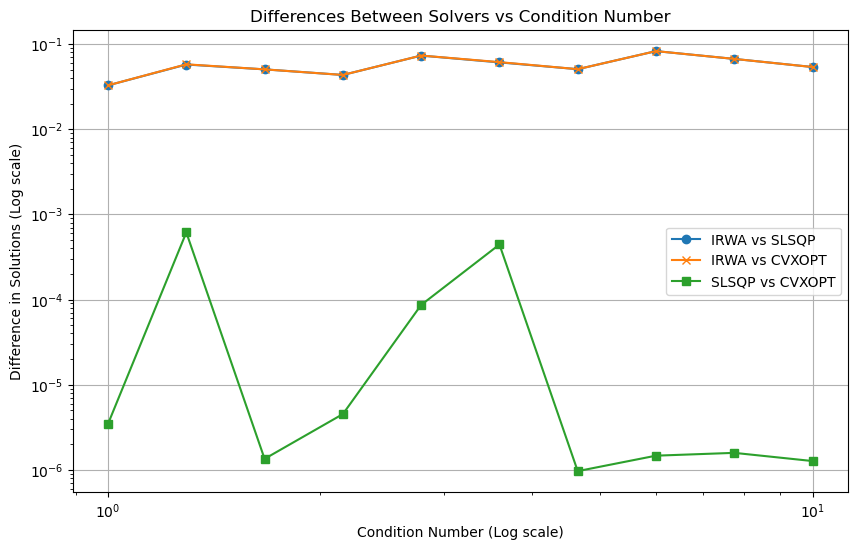

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
from scipy.optimize import minimize
from cvxopt import matrix, solvers

# Update the function to evaluate condition numbers
def evaluate_condition_numbers_and_differences():
    condition_numbers = []
    differences_irwa_slsqp = []
    differences_irwa_cvxopt = []
    differences_slsqp_cvxopt = []

    for cond_number in np.logspace(0, 1, 10):  # Condition numbers from 1 to 10
        # Generate a random QP problem with a controlled condition number
        n = 5
        m1 = 2
        m2 = 3
        H, g, A1, b1, A2, b2, _ = generate_random_qp(n, m1, m2, seed=42)

        # Scale H to achieve the desired condition number
        U, S, Vt = np.linalg.svd(H)
        S = np.linspace(cond_number, 1, len(S))  # Adjust singular values
        H = U @ np.diag(S) @ Vt

        # Solve with IRWA
        x_irwa, _ = IRWA(A1, A2, b1, b2, g, H)

        # Solve with SLSQP
        x_slsqp, _ = solve_qp_with_SLSQP(A1, A2, b1, b2, g, H)

        # Solve with CVXOPT
        x_cvxopt, _ = solve_qp_with_CVXOPT(A1, A2, b1, b2, g, H)

        # Compute differences between solutions
        diff_irwa_slsqp = np.linalg.norm(x_irwa - x_slsqp)
        diff_irwa_cvxopt = np.linalg.norm(x_irwa - x_cvxopt)
        diff_slsqp_cvxopt = np.linalg.norm(x_slsqp - x_cvxopt)

        # Store results
        condition_numbers.append(cond_number)
        differences_irwa_slsqp.append(diff_irwa_slsqp)
        differences_irwa_cvxopt.append(diff_irwa_cvxopt)
        differences_slsqp_cvxopt.append(diff_slsqp_cvxopt)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(condition_numbers, differences_irwa_slsqp, label='IRWA vs SLSQP', marker='o')
    plt.plot(condition_numbers, differences_irwa_cvxopt, label='IRWA vs CVXOPT', marker='x')
    plt.plot(condition_numbers, differences_slsqp_cvxopt, label='SLSQP vs CVXOPT', marker='s')

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Condition Number (Log scale)')
    plt.ylabel('Difference in Solutions (Log scale)')
    plt.title('Differences Between Solvers vs Condition Number')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the evaluation
evaluate_condition_numbers_and_differences()


## 提高矩阵大小查看差值变化


=== 测试案例 1 ===

随机生成的可行解 x_true: [-0.12711553  6.64196542  9.74053991 -0.26163331 -1.88790715 -4.62234246]
迭代 1: 增加罚参数 - rho_eq = 2.00e+02, rho_ineq = 2.00e+02
迭代 2: 增加罚参数 - rho_eq = 4.00e+02, rho_ineq = 4.00e+02
迭代 3: 增加罚参数 - rho_eq = 8.00e+02, rho_ineq = 8.00e+02
迭代 4: 增加罚参数 - rho_eq = 1.60e+03, rho_ineq = 1.60e+03
迭代 5: 增加罚参数 - rho_eq = 3.20e+03, rho_ineq = 3.20e+03
迭代 6: 增加罚参数 - rho_eq = 6.40e+03, rho_ineq = 6.40e+03
迭代 7: 增加罚参数 - rho_eq = 1.28e+04, rho_ineq = 1.28e+04
迭代 8: 增加罚参数 - rho_eq = 2.56e+04, rho_ineq = 2.56e+04
迭代 9: 增加罚参数 - rho_eq = 5.12e+04, rho_ineq = 5.12e+04
迭代 10: 增加罚参数 - rho_eq = 1.02e+05, rho_ineq = 1.02e+05
迭代 11: 增加罚参数 - rho_eq = 2.05e+05, rho_ineq = 2.05e+05
迭代 12: 增加罚参数 - rho_eq = 4.10e+05, rho_ineq = 4.10e+05
收敛于迭代次数：95

=== 测试案例 2 ===

随机生成的可行解 x_true: [ 5.46312401 -2.92785628  1.3232629   7.01368475 -0.72375027 -4.92040937]
迭代 1: 增加罚参数 - rho_eq = 2.00e+02, rho_ineq = 2.00e+02
迭代 2: 增加罚参数 - rho_eq = 4.00e+02, rho_ineq = 4.00e+02
迭代 3: 增加罚参数 - rho_eq = 8.00e

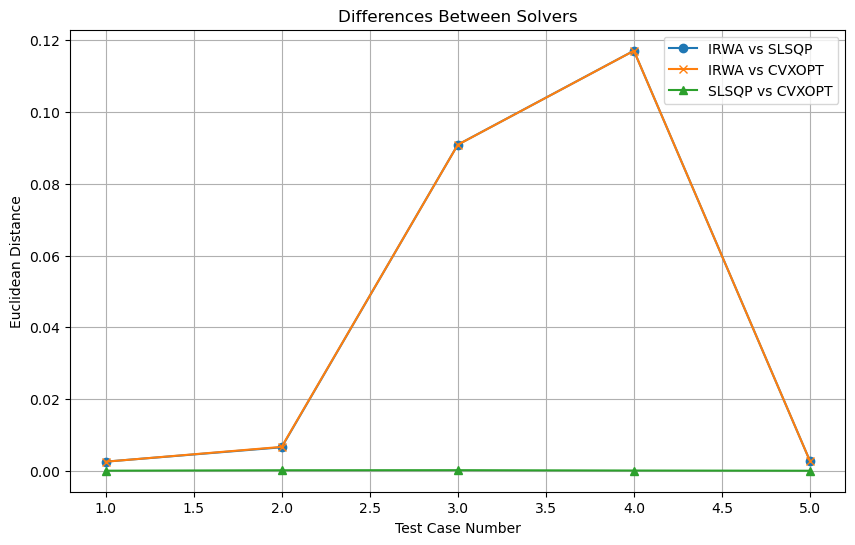

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
from scipy.optimize import minimize
from cvxopt import matrix, solvers

# 生成随机二次规划问题的函数
def generate_random_qp(n, m1, m2, seed=None):
    """
    生成一个随机的二次规划（QP）问题，确保其可行。

    参数：
        n (int): 变量数量。
        m1 (int): 等式约束数量。
        m2 (int): 不等式约束数量。
        seed (int, optional): 随机种子。

    返回：
        H (numpy.ndarray): 目标函数的二次项矩阵。
        g (numpy.ndarray): 目标函数的一次项向量。
        A1 (numpy.ndarray): 等式约束矩阵。
        b1 (numpy.ndarray): 等式约束右侧向量。
        A2 (numpy.ndarray): 不等式约束矩阵。
        b2 (numpy.ndarray): 不等式约束右侧向量。
        x_true (numpy.ndarray): 一个可行解。
    """
    if seed is not None:
        np.random.seed(seed)

    # Generate a feasible solution x_true
    x_true = np.random.uniform(low=-10, high=10, size=n)

    # Generate equality constraints A1 x_true + b1 = 0 => b1 = -A1 x_true
    if m1 > 0:
        A1 = np.random.randn(m1, n)
        b1 = -A1 @ x_true
    else:
        A1 = np.empty((0, n))
        b1 = np.empty(0)

    # Generate inequality constraints A2 x <= b2 => b2 = A2 x_true + s, s >= 1
    if m2 > 0:
        A2 = np.random.randn(m2, n)
        s = np.random.uniform(low=1, high=10, size=m2)
        b2 = A2 @ x_true + s
    else:
        A2 = np.empty((0, n))
        b2 = np.empty(0)

    # Generate a positive definite H
    M = np.random.randn(n, n)
    H = M.T @ M + n * np.eye(n)  # Ensure H is positive definite

    # Generate g
    g = np.random.randn(n)

    return H, g, A1, b1, A2, b2, x_true

# IRWA算法
def IRWA(A1, A2, b1, b2, g, H, x_init=None, eta=0.9, gamma=0.1, M=10,
         sigma=1e-5, sigma_prime=1e-5, max_iter=5000, regularization=1e-4,
         mu_init=1.0, rho_eq_init=100.0, rho_ineq_init=100.0,
         lambda_max=1e8, rho_max=1e8, rho_multiplier=2.0):
    """
    迭代重新加权算法（IRWA）的实现，用于求解带有不等式和等式约束的二次规划问题。

    参数：
        A1 (numpy.ndarray): 等式约束矩阵，形状为 (m1, n)。
        A2 (numpy.ndarray): 不等式约束矩阵，形状为 (m2, n)。
        b1 (numpy.ndarray): 等式约束右侧向量，形状为 (m1,)。
        b2 (numpy.ndarray): 不等式约束右侧向量，形状为 (m2,)。
        g (numpy.ndarray): 目标函数的一次项向量，形状为 (n,)。
        H (numpy.ndarray): 目标函数的二次项矩阵，形状为 (n, n)。
        x_init (numpy.ndarray, optional): 初始解向量，形状为 (n,)。默认值为全零向量。
        eta (float): 更新 epsilon 时的缩放因子，取值范围为 (0,1)。
        gamma (float): 更新 epsilon 时的幂指数，gamma > 0。
        M (float): 更新 epsilon 时的常数，M > 0。
        sigma (float): 收敛判定的 x 变化阈值。
        sigma_prime (float): 收敛判定的 epsilon 变化阈值。
        max_iter (int): 最大迭代次数。
        regularization (float): 正则化参数，用于提高矩阵的条件数。
        mu_init (float): 初始步长因子。
        rho_eq_init (float): 初始等式约束罚参数。
        rho_ineq_init (float): 初始不等式约束罚参数。
        lambda_max (float): 对偶变量的最大值，用于防止过度增长。
        rho_max (float): 罚参数的最大值，防止过度增长。
        rho_multiplier (float): 罚参数增长的倍率。

    返回：
        x (numpy.ndarray): 求解得到的最优解向量，形状为 (n,)。
        k (int): 实际迭代次数。
    """

    def compute_weights(x, epsilon, A, b):
        residual = A @ x - b  # Residual for inequalities
        w = np.zeros_like(epsilon)
        active = residual > 0  # Only active (violated) constraints
        w[active] = 1.0 / np.sqrt(residual[active]**2 + epsilon[active]**2)
        w = np.clip(w, 1e-8, 1e8)
        return w

    def compute_r(q, v, epsilon, gamma, M, eta):
        condition = np.abs(q) <= M * (v**2 + epsilon**2) ** (0.5 + gamma / 2)
        epsilon_new = np.where(condition, eta * epsilon, epsilon)
        return epsilon_new

    m1, n = A1.shape
    m2 = A2.shape[0]

    if x_init is None:
        x_init = np.zeros(n)

    x = x_init.copy()
    epsilon = np.ones(m2)  # Initialize epsilon to 1 to avoid division by zero
    lambda_eq = np.zeros(m1)
    lambda_ineq = np.zeros(m2)

    mu = mu_init
    rho_eq = rho_eq_init
    rho_ineq = rho_ineq_init

    for k in range(1, max_iter + 1):
        # Save old variables
        x_old = x.copy()
        epsilon_old = epsilon.copy()
        lambda_eq_old = lambda_eq.copy()
        lambda_ineq_old = lambda_ineq.copy()

        # Step 1: Compute weights only for active constraints
        w = compute_weights(x, epsilon, A2, b2)
        W = np.diag(w)

        # Step 2: Construct augmented matrix H_tilde and vector h
        H_tilde = H + rho_eq * (A1.T @ A1) + rho_ineq * (A2.T @ W @ A2) + regularization * np.eye(n)
        h = g + A1.T @ lambda_eq + rho_eq * (A1.T @ b1) + A2.T @ (lambda_ineq - rho_ineq * W @ b2)

        # Step 3: Solve H_tilde x = -h
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("error", category=RuntimeWarning)
                x = solve(H_tilde, -h)
        except np.linalg.LinAlgError as e:
            print(f"迭代 {k}: 线性系统求解失败：{e}")
            break
        except RuntimeWarning as e:
            print(f"迭代 {k}: 线性系统求解过程中出现警告：{e}")
            break

        # Step 4: Update dual variables
        residual_eq = A1 @ x + b1 if m1 > 0 else np.array([])
        residual_ineq = A2 @ x - b2

        if m1 > 0:
            lambda_eq += mu * residual_eq
            lambda_eq = np.clip(lambda_eq, -lambda_max, lambda_max)

        lambda_ineq += mu * residual_ineq
        lambda_ineq = np.maximum(lambda_ineq, 0)
        lambda_ineq = np.clip(lambda_ineq, 0, lambda_max)

        # Step 5: Update epsilon
        q = A2 @ x - A2 @ x_old
        v = np.maximum(A2 @ x - b2, 0)
        epsilon = compute_r(q, v, epsilon, gamma, M, eta)

        # Step 6: Compute convergence metrics
        diff_x = np.linalg.norm(x - x_old)
        diff_epsilon = np.linalg.norm(epsilon - epsilon_old)
        primal_resid_eq = np.linalg.norm(residual_eq, ord=np.inf) if m1 > 0 else 0.0
        primal_resid_ineq = np.linalg.norm(np.maximum(residual_ineq, 0), ord=np.inf)
        diff_lambda_eq = np.linalg.norm(lambda_eq - lambda_eq_old, ord=np.inf) if m1 > 0 else 0.0
        diff_lambda_ineq = np.linalg.norm(lambda_ineq - lambda_ineq_old, ord=np.inf)

        # Compute objective function value
        obj_val = 0.5 * x.T @ H @ x + g.T @ x

        # Check convergence
        if (diff_x <= sigma and diff_epsilon <= sigma_prime and
            diff_lambda_eq <= sigma and diff_lambda_ineq <= sigma):
            print(f"收敛于迭代次数：{k}")
            return x, k  # Ensure we return the solution and the number of iterations

        # Step 7: Adjust penalty parameters if necessary
        if primal_resid_eq > 10 * sigma or primal_resid_ineq > 10 * sigma:
            if rho_eq * rho_multiplier > rho_max or rho_ineq * rho_multiplier > rho_max:
                print(f"迭代 {k}: 罚参数达到最大值，无法进一步增加。")
                break
            rho_eq *= rho_multiplier
            rho_ineq *= rho_multiplier
            mu = mu_init  # Reset step size
            print(f"迭代 {k}: 增加罚参数 - rho_eq = {rho_eq:.2e}, rho_ineq = {rho_ineq:.2e}")
        else:
            mu *= eta  # Decrease step size
            mu = max(mu, 1e-6)

    else:
        print("IRWA 达到最大迭代次数。")
    
    # Ensure we return the solution and iteration count if convergence is not reached
    return x, k


# 使用 SLSQP 求解 QP 问题
def solve_qp_with_SLSQP(A1, A2, b1, b2, g, H):
    def objective(x):
        return 0.5 * np.dot(x, H @ x) + np.dot(g, x)
    
    constraints = []
    for i in range(A1.shape[0]):
        constraints.append({
            'type': 'eq',
            'fun': lambda x, A=A1[i], b=b1[i]: np.dot(A, x) + b
        })
    for i in range(A2.shape[0]):
        constraints.append({
            'type': 'ineq',
            'fun': lambda x, A=A2[i], b=b2[i]: b - np.dot(A, x)  
        })
    
    x0 = np.zeros(A1.shape[1])  # 初始解
    
    result = minimize(objective, x0, method='SLSQP', constraints=constraints)
    return result.x, result

# 使用 CVXOPT 求解 QP 问题
def solve_qp_with_CVXOPT(A1, A2, b1, b2, g, H):
    P = matrix(H)
    q = matrix(g)
    G = matrix(A2)
    h = matrix(b2)
    A = matrix(A1)
    b = matrix(-b1)
    
    solvers.options['show_progress'] = False
    solution = solvers.qp(P, q, G, h, A, b)
    
    x = np.array(solution['x']).flatten()
    status = solution['status']
    
    return x, status

# 计算目标函数值
def compute_objective(x, g, H):
    return 0.5 * np.dot(x, H @ x) + np.dot(g, x)

# 比较结果
def compare_results(results, tolerance=1e-4):
    x_irwa = results['IRWA']['x']
    x_slsqp = results['SLSQP']['x']
    x_cvxopt = results['CVXOPT']['x']

    diff_irwa_slsqp = np.linalg.norm(x_irwa - x_slsqp)
    diff_irwa_cvxopt = np.linalg.norm(x_irwa - x_cvxopt)
    diff_slsqp_cvxopt = np.linalg.norm(x_slsqp - x_cvxopt)

    print(f"\nDifference between IRWA and SLSQP solutions (Euclidean norm): {diff_irwa_slsqp:.6e}")
    print(f"Difference between IRWA and CVXOPT solutions (Euclidean norm): {diff_irwa_cvxopt:.6e}")
    print(f"Difference between SLSQP and CVXOPT solutions (Euclidean norm): {diff_slsqp_cvxopt:.6e}")

    consistent_irwa_slsqp = diff_irwa_slsqp <= tolerance
    consistent_irwa_cvxopt = diff_irwa_cvxopt <= tolerance
    consistent_slsqp_cvxopt = diff_slsqp_cvxopt <= tolerance

    if consistent_irwa_slsqp and consistent_irwa_cvxopt and consistent_slsqp_cvxopt:
        print("\nIRWA、SLSQP 和 CVXOPT 求解器的解一致。")
    else:
        print("\nIRWA、SLSQP 和 CVXOPT 求解器的解存在显著差异。")
        print("详细差异如下：")
        print(f"IRWA 与 SLSQP 的解差异：{diff_irwa_slsqp:.6e}")
        print(f"IRWA 与 CVXOPT 的解差异：{diff_irwa_cvxopt:.6e}")
        print(f"SLSQP 与 CVXOPT 的解差异：{diff_slsqp_cvxopt:.6e}")

# 运行随机测试并绘制距离关系图
def run_random_tests(num_tests=5, n=6, m1=2, m2=3, seed=408):
    if seed is not None:
        np.random.seed(seed)

    differences = []

    for test in range(1, num_tests + 1):
        print(f"\n=== 测试案例 {test} ===")
        H, g, A1, b1, A2, b2, x_true = generate_random_qp(n, m1, m2)
        print(f"\n随机生成的可行解 x_true: {x_true}")

        # 运行求解器
        results = run_solvers(H, g, A1, b1, A2, b2)

        # 提取解
        x_irwa = results['IRWA']['x']
        x_slsqp = results['SLSQP']['x']
        x_cvxopt = results['CVXOPT']['x']

        # 计算解之间的欧氏距离
        diff_irwa_slsqp = np.linalg.norm(x_irwa - x_slsqp)
        diff_irwa_cvxopt = np.linalg.norm(x_irwa - x_cvxopt)
        diff_slsqp_cvxopt = np.linalg.norm(x_slsqp - x_cvxopt)

        differences.append((diff_irwa_slsqp, diff_irwa_cvxopt, diff_slsqp_cvxopt))

    # 绘制关系图
    differences = np.array(differences)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_tests + 1), differences[:, 0], label='IRWA vs SLSQP', marker='o')
    plt.plot(range(1, num_tests + 1), differences[:, 1], label='IRWA vs CVXOPT', marker='x')
    plt.plot(range(1, num_tests + 1), differences[:, 2], label='SLSQP vs CVXOPT', marker='^')
    plt.xlabel('Test Case Number')
    plt.ylabel('Euclidean Distance')
    plt.title('Differences Between Solvers')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    run_random_tests(num_tests=5, n=6, m1=2, m2=3, seed=408)

if __name__ == "__main__":
    main()



=== Running tests for n=3, m1=1, m2=1 ===

=== 测试案例 1 ===

随机生成的可行解 x_true: [-0.12711553  6.64196542  9.74053991]
迭代 1: 增加罚参数 - rho_eq = 2.00e+02, rho_ineq = 2.00e+02
迭代 2: 增加罚参数 - rho_eq = 4.00e+02, rho_ineq = 4.00e+02
迭代 3: 增加罚参数 - rho_eq = 8.00e+02, rho_ineq = 8.00e+02
迭代 4: 增加罚参数 - rho_eq = 1.60e+03, rho_ineq = 1.60e+03
迭代 5: 增加罚参数 - rho_eq = 3.20e+03, rho_ineq = 3.20e+03
迭代 6: 增加罚参数 - rho_eq = 6.40e+03, rho_ineq = 6.40e+03
迭代 7: 增加罚参数 - rho_eq = 1.28e+04, rho_ineq = 1.28e+04
迭代 8: 增加罚参数 - rho_eq = 2.56e+04, rho_ineq = 2.56e+04
收敛于迭代次数：89

=== 测试案例 2 ===

随机生成的可行解 x_true: [-7.00589801  7.44182482  4.36390449]
迭代 1: 增加罚参数 - rho_eq = 2.00e+02, rho_ineq = 2.00e+02
迭代 2: 增加罚参数 - rho_eq = 4.00e+02, rho_ineq = 4.00e+02
迭代 3: 增加罚参数 - rho_eq = 8.00e+02, rho_ineq = 8.00e+02
迭代 4: 增加罚参数 - rho_eq = 1.60e+03, rho_ineq = 1.60e+03
迭代 5: 增加罚参数 - rho_eq = 3.20e+03, rho_ineq = 3.20e+03
迭代 6: 增加罚参数 - rho_eq = 6.40e+03, rho_ineq = 6.40e+03
迭代 7: 增加罚参数 - rho_eq = 1.28e+04, rho_ineq = 1.28e+04
迭代 8: 增

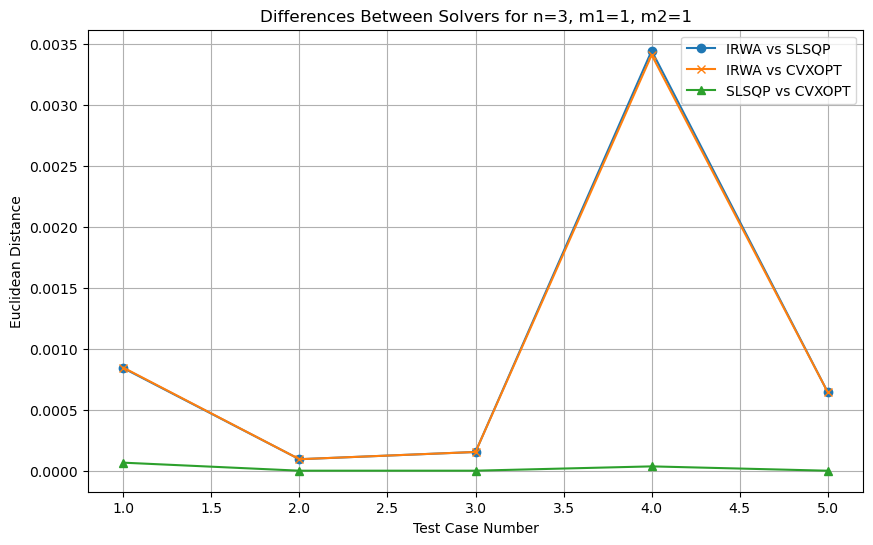


=== Running tests for n=3, m1=1, m2=2 ===

=== 测试案例 1 ===

随机生成的可行解 x_true: [-0.12711553  6.64196542  9.74053991]
迭代 1: 增加罚参数 - rho_eq = 2.00e+02, rho_ineq = 2.00e+02
迭代 2: 增加罚参数 - rho_eq = 4.00e+02, rho_ineq = 4.00e+02
迭代 3: 增加罚参数 - rho_eq = 8.00e+02, rho_ineq = 8.00e+02
迭代 4: 增加罚参数 - rho_eq = 1.60e+03, rho_ineq = 1.60e+03
迭代 5: 增加罚参数 - rho_eq = 3.20e+03, rho_ineq = 3.20e+03
迭代 6: 增加罚参数 - rho_eq = 6.40e+03, rho_ineq = 6.40e+03
迭代 7: 增加罚参数 - rho_eq = 1.28e+04, rho_ineq = 1.28e+04
迭代 8: 增加罚参数 - rho_eq = 2.56e+04, rho_ineq = 2.56e+04
迭代 9: 增加罚参数 - rho_eq = 5.12e+04, rho_ineq = 5.12e+04
迭代 10: 增加罚参数 - rho_eq = 1.02e+05, rho_ineq = 1.02e+05
迭代 11: 增加罚参数 - rho_eq = 2.05e+05, rho_ineq = 2.05e+05
收敛于迭代次数：92

=== 测试案例 2 ===

随机生成的可行解 x_true: [8.63978825 5.28438504 4.49091495]
迭代 1: 增加罚参数 - rho_eq = 2.00e+02, rho_ineq = 2.00e+02
迭代 2: 增加罚参数 - rho_eq = 4.00e+02, rho_ineq = 4.00e+02
迭代 3: 增加罚参数 - rho_eq = 8.00e+02, rho_ineq = 8.00e+02
迭代 4: 增加罚参数 - rho_eq = 1.60e+03, rho_ineq = 1.60e+03
迭代 5: 增加

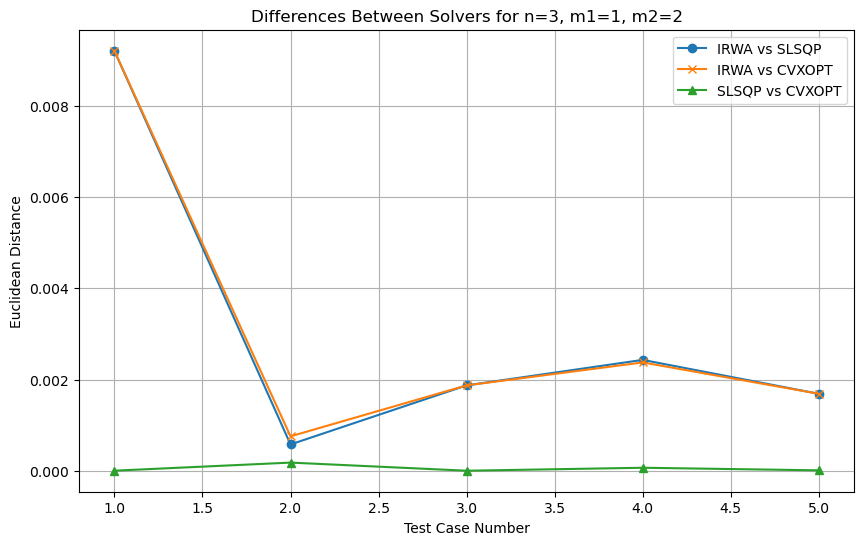


=== Running tests for n=3, m1=1, m2=4 ===

=== 测试案例 1 ===

随机生成的可行解 x_true: [-0.12711553  6.64196542  9.74053991]
迭代 1: 增加罚参数 - rho_eq = 2.00e+02, rho_ineq = 2.00e+02
迭代 2: 增加罚参数 - rho_eq = 4.00e+02, rho_ineq = 4.00e+02
迭代 3: 增加罚参数 - rho_eq = 8.00e+02, rho_ineq = 8.00e+02
迭代 4: 增加罚参数 - rho_eq = 1.60e+03, rho_ineq = 1.60e+03
迭代 5: 增加罚参数 - rho_eq = 3.20e+03, rho_ineq = 3.20e+03
迭代 6: 增加罚参数 - rho_eq = 6.40e+03, rho_ineq = 6.40e+03
迭代 7: 增加罚参数 - rho_eq = 1.28e+04, rho_ineq = 1.28e+04
迭代 8: 增加罚参数 - rho_eq = 2.56e+04, rho_ineq = 2.56e+04
迭代 9: 增加罚参数 - rho_eq = 5.12e+04, rho_ineq = 5.12e+04
收敛于迭代次数：95

=== 测试案例 2 ===

随机生成的可行解 x_true: [ 6.70098226  7.9353803  -9.86403061]
迭代 1: 增加罚参数 - rho_eq = 2.00e+02, rho_ineq = 2.00e+02
迭代 2: 增加罚参数 - rho_eq = 4.00e+02, rho_ineq = 4.00e+02
迭代 3: 增加罚参数 - rho_eq = 8.00e+02, rho_ineq = 8.00e+02
迭代 4: 增加罚参数 - rho_eq = 1.60e+03, rho_ineq = 1.60e+03
迭代 5: 增加罚参数 - rho_eq = 3.20e+03, rho_ineq = 3.20e+03
迭代 6: 增加罚参数 - rho_eq = 6.40e+03, rho_ineq = 6.40e+03
迭代 7: 增

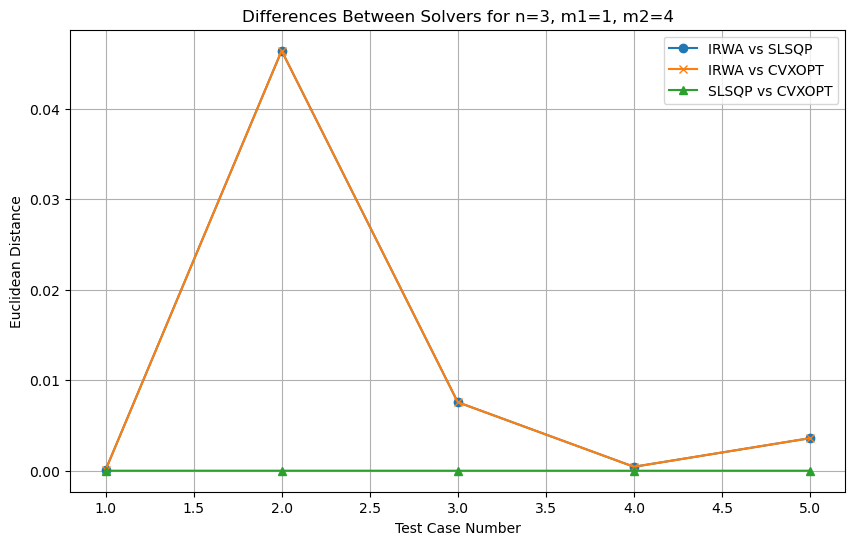


=== Running tests for n=3, m1=3, m2=1 ===

=== 测试案例 1 ===

随机生成的可行解 x_true: [-0.12711553  6.64196542  9.74053991]
迭代 1: 增加罚参数 - rho_eq = 2.00e+02, rho_ineq = 2.00e+02
迭代 2: 增加罚参数 - rho_eq = 4.00e+02, rho_ineq = 4.00e+02
迭代 3: 增加罚参数 - rho_eq = 8.00e+02, rho_ineq = 8.00e+02
迭代 4: 增加罚参数 - rho_eq = 1.60e+03, rho_ineq = 1.60e+03
迭代 5: 增加罚参数 - rho_eq = 3.20e+03, rho_ineq = 3.20e+03
迭代 6: 增加罚参数 - rho_eq = 6.40e+03, rho_ineq = 6.40e+03
迭代 7: 增加罚参数 - rho_eq = 1.28e+04, rho_ineq = 1.28e+04
迭代 8: 增加罚参数 - rho_eq = 2.56e+04, rho_ineq = 2.56e+04
迭代 9: 增加罚参数 - rho_eq = 5.12e+04, rho_ineq = 5.12e+04
迭代 10: 增加罚参数 - rho_eq = 1.02e+05, rho_ineq = 1.02e+05
迭代 11: 增加罚参数 - rho_eq = 2.05e+05, rho_ineq = 2.05e+05
迭代 12: 增加罚参数 - rho_eq = 4.10e+05, rho_ineq = 4.10e+05
收敛于迭代次数：89

=== 测试案例 2 ===

随机生成的可行解 x_true: [-4.46833582 -0.2673686  -1.47198917]
迭代 1: 增加罚参数 - rho_eq = 2.00e+02, rho_ineq = 2.00e+02
迭代 2: 增加罚参数 - rho_eq = 4.00e+02, rho_ineq = 4.00e+02
迭代 3: 增加罚参数 - rho_eq = 8.00e+02, rho_ineq = 8.00e+02
迭代 4

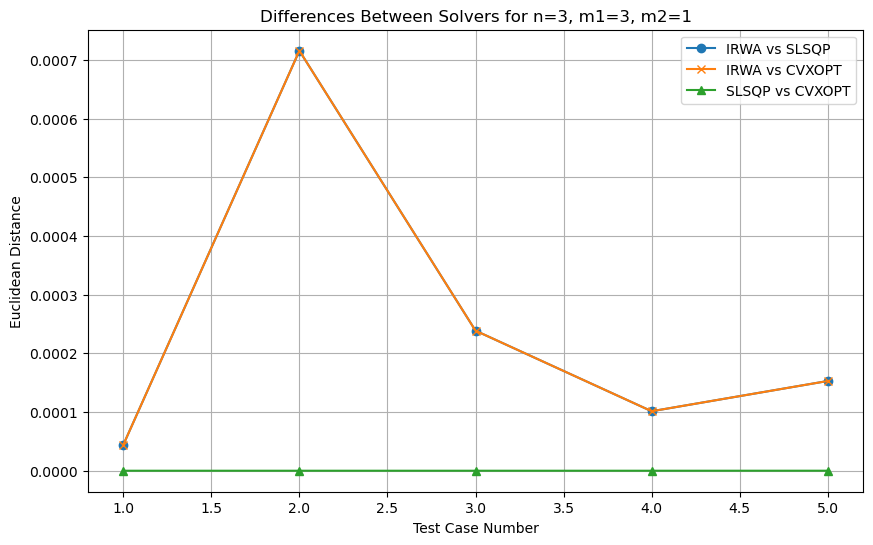


=== Running tests for n=3, m1=3, m2=2 ===

=== 测试案例 1 ===

随机生成的可行解 x_true: [-0.12711553  6.64196542  9.74053991]
迭代 1: 增加罚参数 - rho_eq = 2.00e+02, rho_ineq = 2.00e+02
迭代 2: 增加罚参数 - rho_eq = 4.00e+02, rho_ineq = 4.00e+02
迭代 3: 增加罚参数 - rho_eq = 8.00e+02, rho_ineq = 8.00e+02
迭代 4: 增加罚参数 - rho_eq = 1.60e+03, rho_ineq = 1.60e+03
迭代 5: 增加罚参数 - rho_eq = 3.20e+03, rho_ineq = 3.20e+03
迭代 6: 增加罚参数 - rho_eq = 6.40e+03, rho_ineq = 6.40e+03
迭代 7: 增加罚参数 - rho_eq = 1.28e+04, rho_ineq = 1.28e+04
迭代 8: 增加罚参数 - rho_eq = 2.56e+04, rho_ineq = 2.56e+04
迭代 9: 增加罚参数 - rho_eq = 5.12e+04, rho_ineq = 5.12e+04
迭代 10: 增加罚参数 - rho_eq = 1.02e+05, rho_ineq = 1.02e+05
迭代 11: 增加罚参数 - rho_eq = 2.05e+05, rho_ineq = 2.05e+05
迭代 12: 增加罚参数 - rho_eq = 4.10e+05, rho_ineq = 4.10e+05
收敛于迭代次数：92

=== 测试案例 2 ===

随机生成的可行解 x_true: [-7.55486999 -0.9307783   6.70098226]
迭代 1: 增加罚参数 - rho_eq = 2.00e+02, rho_ineq = 2.00e+02
迭代 2: 增加罚参数 - rho_eq = 4.00e+02, rho_ineq = 4.00e+02
迭代 3: 增加罚参数 - rho_eq = 8.00e+02, rho_ineq = 8.00e+02
迭代 4

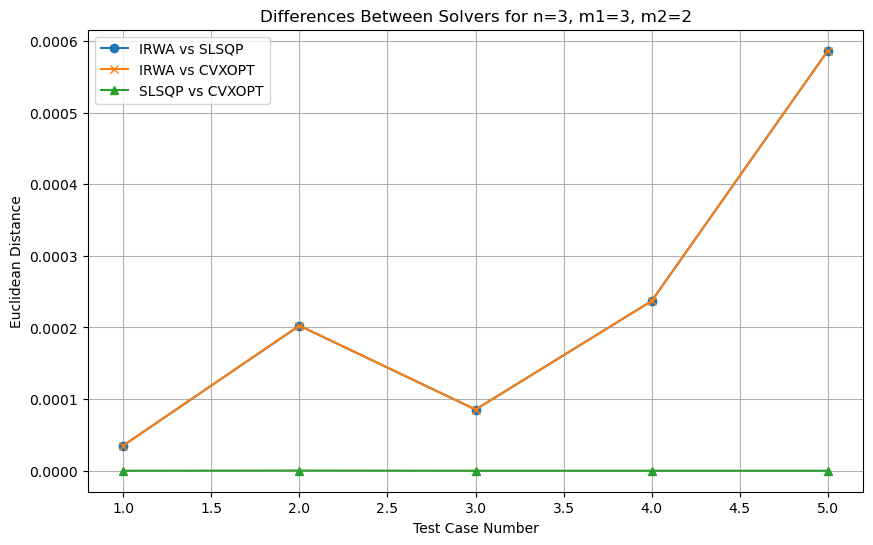


=== Running tests for n=3, m1=3, m2=4 ===

=== 测试案例 1 ===

随机生成的可行解 x_true: [-0.12711553  6.64196542  9.74053991]
迭代 1: 增加罚参数 - rho_eq = 2.00e+02, rho_ineq = 2.00e+02
迭代 2: 增加罚参数 - rho_eq = 4.00e+02, rho_ineq = 4.00e+02
迭代 3: 增加罚参数 - rho_eq = 8.00e+02, rho_ineq = 8.00e+02
迭代 4: 增加罚参数 - rho_eq = 1.60e+03, rho_ineq = 1.60e+03
迭代 5: 增加罚参数 - rho_eq = 3.20e+03, rho_ineq = 3.20e+03
迭代 6: 增加罚参数 - rho_eq = 6.40e+03, rho_ineq = 6.40e+03
迭代 7: 增加罚参数 - rho_eq = 1.28e+04, rho_ineq = 1.28e+04
迭代 8: 增加罚参数 - rho_eq = 2.56e+04, rho_ineq = 2.56e+04
迭代 9: 增加罚参数 - rho_eq = 5.12e+04, rho_ineq = 5.12e+04
迭代 10: 增加罚参数 - rho_eq = 1.02e+05, rho_ineq = 1.02e+05
迭代 11: 增加罚参数 - rho_eq = 2.05e+05, rho_ineq = 2.05e+05
迭代 12: 增加罚参数 - rho_eq = 4.10e+05, rho_ineq = 4.10e+05
迭代 13: 增加罚参数 - rho_eq = 8.19e+05, rho_ineq = 8.19e+05
收敛于迭代次数：95

=== 测试案例 2 ===

随机生成的可行解 x_true: [-6.64005191 -4.65614768 -1.89912341]
迭代 1: 增加罚参数 - rho_eq = 2.00e+02, rho_ineq = 2.00e+02
迭代 2: 增加罚参数 - rho_eq = 4.00e+02, rho_ineq = 4.00e+02
迭代 

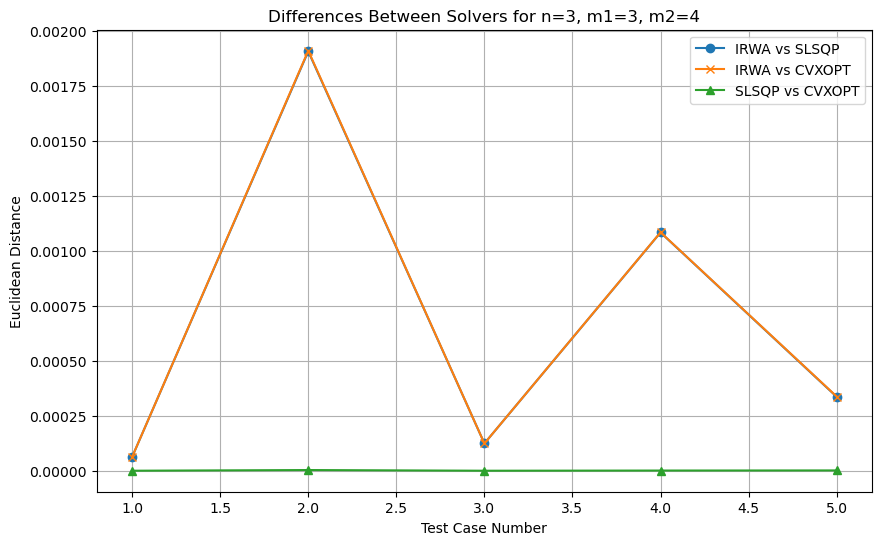


=== Running tests for n=3, m1=5, m2=1 ===

=== 测试案例 1 ===

随机生成的可行解 x_true: [-0.12711553  6.64196542  9.74053991]
迭代 1: 增加罚参数 - rho_eq = 2.00e+02, rho_ineq = 2.00e+02
迭代 2: 增加罚参数 - rho_eq = 4.00e+02, rho_ineq = 4.00e+02
迭代 3: 增加罚参数 - rho_eq = 8.00e+02, rho_ineq = 8.00e+02
迭代 4: 增加罚参数 - rho_eq = 1.60e+03, rho_ineq = 1.60e+03
迭代 5: 增加罚参数 - rho_eq = 3.20e+03, rho_ineq = 3.20e+03
迭代 6: 增加罚参数 - rho_eq = 6.40e+03, rho_ineq = 6.40e+03
迭代 7: 增加罚参数 - rho_eq = 1.28e+04, rho_ineq = 1.28e+04
迭代 8: 增加罚参数 - rho_eq = 2.56e+04, rho_ineq = 2.56e+04
迭代 9: 增加罚参数 - rho_eq = 5.12e+04, rho_ineq = 5.12e+04
迭代 10: 增加罚参数 - rho_eq = 1.02e+05, rho_ineq = 1.02e+05
迭代 11: 增加罚参数 - rho_eq = 2.05e+05, rho_ineq = 2.05e+05
迭代 12: 增加罚参数 - rho_eq = 4.10e+05, rho_ineq = 4.10e+05
迭代 13: 增加罚参数 - rho_eq = 8.19e+05, rho_ineq = 8.19e+05
收敛于迭代次数：89


ValueError: Rank(A) < p or Rank([P; G; A]) < n

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
from scipy.optimize import minimize
from cvxopt import matrix, solvers

# 生成随机二次规划问题的函数
def generate_random_qp(n, m1, m2, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # Generate a feasible solution x_true
    x_true = np.random.uniform(low=-10, high=10, size=n)

    # Generate equality constraints A1 x_true + b1 = 0 => b1 = -A1 x_true
    if m1 > 0:
        A1 = np.random.randn(m1, n)
        b1 = -A1 @ x_true
    else:
        A1 = np.empty((0, n))
        b1 = np.empty(0)

    # Generate inequality constraints A2 x <= b2 => b2 = A2 x_true + s, s >= 1
    if m2 > 0:
        A2 = np.random.randn(m2, n)
        s = np.random.uniform(low=1, high=10, size=m2)
        b2 = A2 @ x_true + s
    else:
        A2 = np.empty((0, n))
        b2 = np.empty(0)

    # Generate a positive definite H
    M = np.random.randn(n, n)
    H = M.T @ M + n * np.eye(n)  # Ensure H is positive definite

    # Generate g
    g = np.random.randn(n)

    return H, g, A1, b1, A2, b2, x_true

# IRWA算法
def IRWA(A1, A2, b1, b2, g, H, x_init=None, eta=0.9, gamma=0.1, M=10,
         sigma=1e-5, sigma_prime=1e-5, max_iter=5000, regularization=1e-4,
         mu_init=1.0, rho_eq_init=100.0, rho_ineq_init=100.0,
         lambda_max=1e8, rho_max=1e8, rho_multiplier=2.0):
    """
    迭代重新加权算法（IRWA）的实现，用于求解带有不等式和等式约束的二次规划问题。

    参数：
        A1 (numpy.ndarray): 等式约束矩阵，形状为 (m1, n)。
        A2 (numpy.ndarray): 不等式约束矩阵，形状为 (m2, n)。
        b1 (numpy.ndarray): 等式约束右侧向量，形状为 (m1,)。
        b2 (numpy.ndarray): 不等式约束右侧向量，形状为 (m2,)。
        g (numpy.ndarray): 目标函数的一次项向量，形状为 (n,)。
        H (numpy.ndarray): 目标函数的二次项矩阵，形状为 (n, n)。
        x_init (numpy.ndarray, optional): 初始解向量，形状为 (n,)。默认值为全零向量。
        eta (float): 更新 epsilon 时的缩放因子，取值范围为 (0,1)。
        gamma (float): 更新 epsilon 时的幂指数，gamma > 0。
        M (float): 更新 epsilon 时的常数，M > 0。
        sigma (float): 收敛判定的 x 变化阈值。
        sigma_prime (float): 收敛判定的 epsilon 变化阈值。
        max_iter (int): 最大迭代次数。
        regularization (float): 正则化参数，用于提高矩阵的条件数。
        mu_init (float): 初始步长因子。
        rho_eq_init (float): 初始等式约束罚参数。
        rho_ineq_init (float): 初始不等式约束罚参数。
        lambda_max (float): 对偶变量的最大值，用于防止过度增长。
        rho_max (float): 罚参数的最大值，防止过度增长。
        rho_multiplier (float): 罚参数增长的倍率。

    返回：
        x (numpy.ndarray): 求解得到的最优解向量，形状为 (n,)。
        k (int): 实际迭代次数。
    """

    def compute_weights(x, epsilon, A, b):
        residual = A @ x - b  # Residual for inequalities
        w = np.zeros_like(epsilon)
        active = residual > 0  # Only active (violated) constraints
        w[active] = 1.0 / np.sqrt(residual[active]**2 + epsilon[active]**2)
        w = np.clip(w, 1e-8, 1e8)
        return w

    def compute_r(q, v, epsilon, gamma, M, eta):
        condition = np.abs(q) <= M * (v**2 + epsilon**2) ** (0.5 + gamma / 2)
        epsilon_new = np.where(condition, eta * epsilon, epsilon)
        return epsilon_new

    m1, n = A1.shape
    m2 = A2.shape[0]

    if x_init is None:
        x_init = np.zeros(n)

    x = x_init.copy()
    epsilon = np.ones(m2)  # Initialize epsilon to 1 to avoid division by zero
    lambda_eq = np.zeros(m1)
    lambda_ineq = np.zeros(m2)

    mu = mu_init
    rho_eq = rho_eq_init
    rho_ineq = rho_ineq_init

    for k in range(1, max_iter + 1):
        # Save old variables
        x_old = x.copy()
        epsilon_old = epsilon.copy()
        lambda_eq_old = lambda_eq.copy()
        lambda_ineq_old = lambda_ineq.copy()

        # Step 1: Compute weights only for active constraints
        w = compute_weights(x, epsilon, A2, b2)
        W = np.diag(w)

        # Step 2: Construct augmented matrix H_tilde and vector h
        H_tilde = H + rho_eq * (A1.T @ A1) + rho_ineq * (A2.T @ W @ A2) + regularization * np.eye(n)
        h = g + A1.T @ lambda_eq + rho_eq * (A1.T @ b1) + A2.T @ (lambda_ineq - rho_ineq * W @ b2)

        # Step 3: Solve H_tilde x = -h
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("error", category=RuntimeWarning)
                x = solve(H_tilde, -h)
        except np.linalg.LinAlgError as e:
            print(f"迭代 {k}: 线性系统求解失败：{e}")
            break
        except RuntimeWarning as e:
            print(f"迭代 {k}: 线性系统求解过程中出现警告：{e}")
            break

        # Step 4: Update dual variables
        residual_eq = A1 @ x + b1 if m1 > 0 else np.array([])
        residual_ineq = A2 @ x - b2

        if m1 > 0:
            lambda_eq += mu * residual_eq
            lambda_eq = np.clip(lambda_eq, -lambda_max, lambda_max)

        lambda_ineq += mu * residual_ineq
        lambda_ineq = np.maximum(lambda_ineq, 0)
        lambda_ineq = np.clip(lambda_ineq, 0, lambda_max)

        # Step 5: Update epsilon
        q = A2 @ x - A2 @ x_old
        v = np.maximum(A2 @ x - b2, 0)
        epsilon = compute_r(q, v, epsilon, gamma, M, eta)

        # Step 6: Compute convergence metrics
        diff_x = np.linalg.norm(x - x_old)
        diff_epsilon = np.linalg.norm(epsilon - epsilon_old)
        primal_resid_eq = np.linalg.norm(residual_eq, ord=np.inf) if m1 > 0 else 0.0
        primal_resid_ineq = np.linalg.norm(np.maximum(residual_ineq, 0), ord=np.inf)
        diff_lambda_eq = np.linalg.norm(lambda_eq - lambda_eq_old, ord=np.inf) if m1 > 0 else 0.0
        diff_lambda_ineq = np.linalg.norm(lambda_ineq - lambda_ineq_old, ord=np.inf)

        # Compute objective function value
        obj_val = 0.5 * x.T @ H @ x + g.T @ x

        # Check convergence
        if (diff_x <= sigma and diff_epsilon <= sigma_prime and
            diff_lambda_eq <= sigma and diff_lambda_ineq <= sigma):
            print(f"收敛于迭代次数：{k}")
            return x, k  # Ensure we return the solution and the number of iterations

        # Step 7: Adjust penalty parameters if necessary
        if primal_resid_eq > 10 * sigma or primal_resid_ineq > 10 * sigma:
            if rho_eq * rho_multiplier > rho_max or rho_ineq * rho_multiplier > rho_max:
                print(f"迭代 {k}: 罚参数达到最大值，无法进一步增加。")
                break
            rho_eq *= rho_multiplier
            rho_ineq *= rho_multiplier
            mu = mu_init  # Reset step size
            print(f"迭代 {k}: 增加罚参数 - rho_eq = {rho_eq:.2e}, rho_ineq = {rho_ineq:.2e}")
        else:
            mu *= eta  # Decrease step size
            mu = max(mu, 1e-6)

    else:
        print("IRWA 达到最大迭代次数。")
    
    # Ensure we return the solution and iteration count if convergence is not reached
    return x, k

# 使用 SLSQP 求解 QP 问题
def solve_qp_with_SLSQP(A1, A2, b1, b2, g, H):
    def objective(x):
        return 0.5 * np.dot(x, H @ x) + np.dot(g, x)
    
    constraints = []
    for i in range(A1.shape[0]):
        constraints.append({
            'type': 'eq',
            'fun': lambda x, A=A1[i], b=b1[i]: np.dot(A, x) + b
        })
    for i in range(A2.shape[0]):
        constraints.append({
            'type': 'ineq',
            'fun': lambda x, A=A2[i], b=b2[i]: b - np.dot(A, x)  
        })
    
    x0 = np.zeros(A1.shape[1])  # 初始解
    
    result = minimize(objective, x0, method='SLSQP', constraints=constraints)
    return result.x, result

# 使用 CVXOPT 求解 QP 问题
def solve_qp_with_CVXOPT(A1, A2, b1, b2, g, H):
    P = matrix(H)
    q = matrix(g)
    G = matrix(A2)
    h = matrix(b2)
    A = matrix(A1)
    b = matrix(-b1)
    
    solvers.options['show_progress'] = False
    solution = solvers.qp(P, q, G, h, A, b)
    
    x = np.array(solution['x']).flatten()
    status = solution['status']
    
    return x, status

# 计算目标函数值
def compute_objective(x, g, H):
    return 0.5 * np.dot(x, H @ x) + np.dot(g, x)

# 比较结果
def compare_results(results, tolerance=1e-4):
    x_irwa = results['IRWA']['x']
    x_slsqp = results['SLSQP']['x']
    x_cvxopt = results['CVXOPT']['x']

    diff_irwa_slsqp = np.linalg.norm(x_irwa - x_slsqp)
    diff_irwa_cvxopt = np.linalg.norm(x_irwa - x_cvxopt)
    diff_slsqp_cvxopt = np.linalg.norm(x_slsqp - x_cvxopt)

    print(f"\nDifference between IRWA and SLSQP solutions (Euclidean norm): {diff_irwa_slsqp:.6e}")
    print(f"Difference between IRWA and CVXOPT solutions (Euclidean norm): {diff_irwa_cvxopt:.6e}")
    print(f"Difference between SLSQP and CVXOPT solutions (Euclidean norm): {diff_slsqp_cvxopt:.6e}")

    consistent_irwa_slsqp = diff_irwa_slsqp <= tolerance
    consistent_irwa_cvxopt = diff_irwa_cvxopt <= tolerance
    consistent_slsqp_cvxopt = diff_slsqp_cvxopt <= tolerance

    if consistent_irwa_slsqp and consistent_irwa_cvxopt and consistent_slsqp_cvxopt:
        print("\nIRWA、SLSQP 和 CVXOPT 求解器的解一致。")
    else:
        print("\nIRWA、SLSQP 和 CVXOPT 求解器的解存在显著差异。")
        print("详细差异如下：")
        print(f"IRWA 与 SLSQP 的解差异：{diff_irwa_slsqp:.6e}")
        print(f"IRWA 与 CVXOPT 的解差异：{diff_irwa_cvxopt:.6e}")
        print(f"SLSQP 与 CVXOPT 的解差异：{diff_slsqp_cvxopt:.6e}")

# 运行随机测试并绘制距离关系图
def run_random_tests(num_tests=5, n=6, m1=2, m2=3, seed=408):
    if seed is not None:
        np.random.seed(seed)

    differences = []

    for test in range(1, num_tests + 1):
        print(f"\n=== 测试案例 {test} ===")
        H, g, A1, b1, A2, b2, x_true = generate_random_qp(n, m1, m2)
        print(f"\n随机生成的可行解 x_true: {x_true}")

        # 运行求解器
        results = run_solvers(H, g, A1, b1, A2, b2)

        # 提取解
        x_irwa = results['IRWA']['x']
        x_slsqp = results['SLSQP']['x']
        x_cvxopt = results['CVXOPT']['x']

        # 计算解之间的欧氏距离
        diff_irwa_slsqp = np.linalg.norm(x_irwa - x_slsqp)
        diff_irwa_cvxopt = np.linalg.norm(x_irwa - x_cvxopt)
        diff_slsqp_cvxopt = np.linalg.norm(x_slsqp - x_cvxopt)

        differences.append((diff_irwa_slsqp, diff_irwa_cvxopt, diff_slsqp_cvxopt))

    # 绘制关系图
    differences = np.array(differences)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_tests + 1), differences[:, 0], label='IRWA vs SLSQP', marker='o')
    plt.plot(range(1, num_tests + 1), differences[:, 1], label='IRWA vs CVXOPT', marker='x')
    plt.plot(range(1, num_tests + 1), differences[:, 2], label='SLSQP vs CVXOPT', marker='^')
    plt.xlabel('Test Case Number')
    plt.ylabel('Euclidean Distance')
    plt.title(f'Differences Between Solvers for n={n}, m1={m1}, m2={m2}')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    n_values = [3, 6, 9]
    m1_values = [1, 3, 5]
    m2_values = [1, 2, 4]

    # 遍历不同的 n, m1, m2 组合
    for n in n_values:
        for m1 in m1_values:
            for m2 in m2_values:
                print(f"\n=== Running tests for n={n}, m1={m1}, m2={m2} ===")
                run_random_tests(num_tests=5, n=n, m1=m1, m2=m2, seed=408)

if __name__ == "__main__":
    main()